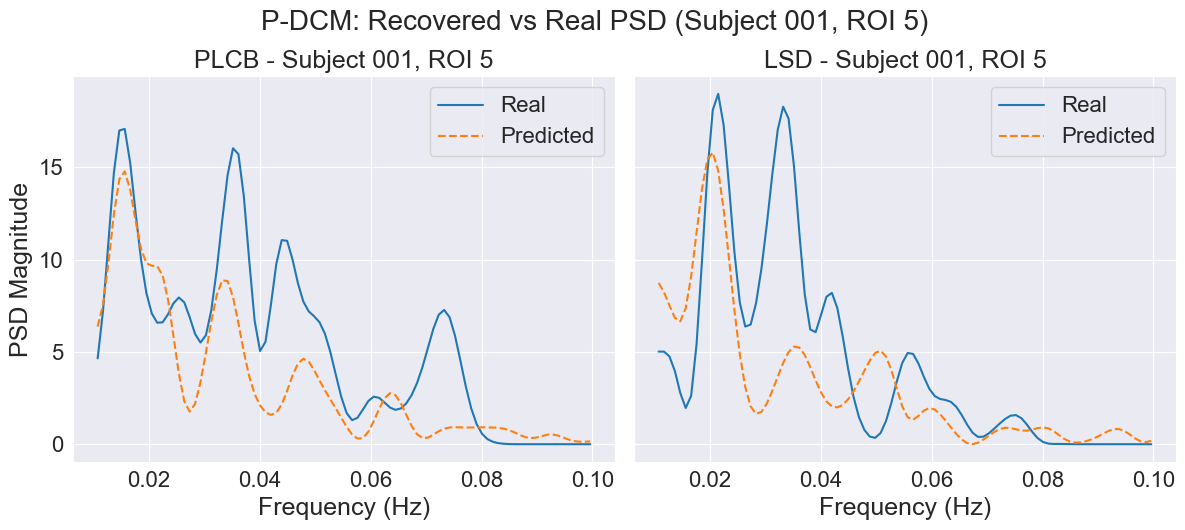

In [1]:
from PDCM.euler_maruyama import simulate_bold_euler_maruyama
import os
import json
import torch
import matplotlib.pyplot as plt

from helper_functions import load_single_time_series, filter_frequencies
from scipy_to_torch import torch_csd
from PDCM.PDCMBOLDModel import PDCMMODEL

subject_id = 1
roi_index = 5
conditions = ["PLCB", "LSD"]
fs = 0.5
h = 0.01
padded_id = f"{subject_id:03d}"
base_path = "/Users/xuenbei/Desktop/finalyearproject"

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for idx, cond in enumerate(conditions):
    # Load real BOLD
    ts_path = f"{base_path}/time_series/sub-{padded_id}-{cond}-ROI{roi_index}.txt"
    real_bold = torch.tensor(load_single_time_series(ts_path), dtype=torch.float32)
    real_bold = real_bold / real_bold.std()

    # Load model params
    results_path = f"{base_path}/PDCM/fitted_data/sub-{padded_id}/roi-{roi_index}-{cond}_results.json"
    with open(results_path, 'r') as f:
        result_data = json.load(f)
    params = {k: float(v) for k, v in result_data["final_parameters"].items()}

    # Rebuild model
    model = PDCMMODEL(
        ignore_range=True,
        phi=params['phi'], varphi=params['varphi'], chi=params['chi'],
        mtt=params['mtt'], tau=params['tau'], sigma=params['sigma'],
        mu=params['mu'], lamb=params['lamb'], alpha=params['alpha'], E0=params['E0'],
        device='cpu'
    )

    # Simulate predicted BOLD
    t_sim = torch.arange(0, len(real_bold) * 2, h)
    _, pred_bold = simulate_bold_euler_maruyama(
        model=model, time=t_sim, h=h,
        alpha_v=params["alpha_v"], beta_v=params["beta_v"],
        alpha_e=params["alpha_e"], beta_e=params["beta_e"],
        desired_TR=2.0, add_state_noise=True, add_obs_noise=True
    )

    # Normalise and detach
    real_bold = real_bold.detach().cpu()
    pred_bold = pred_bold.detach().cpu()
    pred_bold = pred_bold / pred_bold.std()

    # Compute PSDs
    f1, csd_real = torch_csd(real_bold, real_bold, fs=fs, nperseg=128, nfft=512)
    f1, csd_real = filter_frequencies(f1, csd_real, 0.01, 0.1)

    f2, csd_pred = torch_csd(pred_bold, pred_bold, fs=fs, nperseg=128, nfft=512)
    f2, csd_pred = filter_frequencies(f2, csd_pred, 0.01, 0.1)

    true_mag = torch.sqrt(csd_real.real ** 2 + csd_real.imag ** 2).detach().cpu().numpy()
    pred_mag = torch.sqrt(csd_pred.real ** 2 + csd_pred.imag ** 2).detach().cpu().numpy()

    ax = axes[idx]
    ax.plot(f1, true_mag, label="Real")
    ax.plot(f2, pred_mag, label="Predicted", linestyle="--")
    ax.set_title(f"{cond} - Subject {padded_id}, ROI {roi_index}", fontsize = 18)
    ax.set_xlabel("Frequency (Hz)", fontsize = 18)
    if idx == 0:
        ax.set_ylabel("PSD Magnitude", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(fontsize = 16)
    ax.grid(True)

plt.tight_layout()
plt.suptitle(f"P-DCM: Recovered vs Real PSD (Subject {padded_id}, ROI {roi_index})", y=1.05, fontsize=20)
plt.show()


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp, ttest_rel
from statsmodels.stats.multitest import multipletests

sns.set(style="whitegrid")

base_dir = "/Users/xuenbei/Desktop/finalyearproject/PDCM/fitted_data"

subject_ids = [1, 2, 3, 4, 6, 10, 11, 12, 19, 20]
rois = list(range(0,9)) 

#LH VS range(0, 9)  # ROI Index 0 to 8
#RH VS range(50, 58)  # ROI Index 50 to 57
#LH somatomotor cortex range(9, 15)  # ROI Index 9 to 14
#RH somatomotor cortex range(58, 66)  # ROI Index 58 to 65
#LH Dorsal attention network range(58, 66)  # ROI Index 58 to 65
#RH Dorsal attention network range(66, 72)  # ROI Index 66 to 71
#LH Salience/Ventral Attention Network range(23, 30)  # ROI Index 23 to 29
#RH  Salience/Ventral Attention Network range(73, 77)  # ROI Index 73 to 76
#LH Limbic Network range(30, 33)  # ROI Index 30 to 32
#RH Limbic Network range(78, 80)  # ROI Index 78 to 79
#LH Control Network (Frontoparietal) range(33, 37)  # ROI Index 33 to 36
#RH Control Network (Frontoparietal) range(80, 89)  # ROI Index 80 to 87
#LH Default Mode Network range(37, 50)  # ROI Index 37 to 49
#RH Default Mode Network range(89, 100)  # ROI Index 89 to 99

params = ["phi", "varphi", "chi", "mtt", "tau", "alpha_v", "beta_v", "alpha_e", "beta_e", "alpha", "E0"]
reference_values = {
    "phi": 1.5, "varphi": 0.6, "chi": 0.6, "mtt": 2.0, "tau": 4.0,
    "alpha": 0.32, "E0": 0.4, "alpha_v": 0.5, "beta_v": 0.5,
    "alpha_e": 0.5, "beta_e": 0.5
}

# Load all parameter values
all_data = []

for subj in subject_ids:
    for roi in rois:
        for condition in ["PLCB", "LSD"]:
            path = os.path.join(base_dir, f"sub-{subj:03d}", f"roi-{roi}-{condition}_results.json")
            if not os.path.exists(path):
                continue
            with open(path) as f:
                data = json.load(f).get("final_parameters", {})
            row = {"subject": subj, "roi": roi, "condition": condition}
            for param in params:
                row[param] = data.get(param, np.nan)
            all_data.append(row)

df = pd.DataFrame(all_data)
df.head()

# One-sample t-tests vs reference values

t_results = []

for param in params:
    values = df[df["condition"] == "PLCB"][param].dropna()
    ref = reference_values.get(param, 0.0)
    if len(values) < 5:
        continue
    t_stat, p_val = ttest_1samp(values, popmean=ref)
    t_results.append({
        "parameter": param,
        "mean": values.mean(),
        "std": values.std(),
        "reference": ref,
        "t_stat": t_stat,
        "p_value": p_val
    })

results_df = pd.DataFrame(t_results)

# Multiple corrections 
pvals = results_df["p_value"].values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

results_df["p_fdr_bh"] = p_fdr
results_df["reject_fdr_bh"] = rej_fdr
results_df["p_bonferroni"] = p_bonf
results_df["reject_bonferroni"] = rej_bonf
results_df["p_holm"] = p_holm
results_df["reject_holm"] = rej_holm
results_df["reject_raw"] = results_df["p_value"] < 0.05

def interpret_p(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "marginally significant"
    else:
        return "not significant"

def interpret_result(p, mean, ref):
    direction = "↑ above ref" if mean > ref else "↓ below ref"
    return f"{interpret_p(p)}, {direction}"

# Add interpretation columns
results_df["interpret_raw"] = results_df.apply(
    lambda row: interpret_result(row["p_value"], row["mean"], row["reference"]), axis=1)
results_df["interpret_fdr_bh"] = results_df.apply(
    lambda row: interpret_result(row["p_fdr_bh"], row["mean"], row["reference"]), axis=1)
results_df["interpret_bonferroni"] = results_df.apply(
    lambda row: interpret_result(row["p_bonferroni"], row["mean"], row["reference"]), axis=1)
results_df["interpret_holm"] = results_df.apply(
    lambda row: interpret_result(row["p_holm"], row["mean"], row["reference"]), axis=1)

results_df = results_df[[
    "parameter", "mean", "std", "reference", "t_stat", "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

results_df.sort_values("p_fdr_bh", inplace=True)
results_df


parameter       mean       std  reference     t_stat       p_value  \
7    alpha_e  10.780890  5.500857       0.50  17.730527  5.926308e-31   
4        tau  18.594201  8.730511       4.00  15.858492  1.146183e-27   
5    alpha_v  10.208197  5.888355       0.50  15.641046  2.841352e-27   
8     beta_e   1.864282  1.289195       0.50  10.039376  2.655352e-16   
6     beta_v   1.410966  1.143042       0.50   7.560686  3.429268e-11   
3        mtt   2.274781  1.341975       2.00   1.942511  5.523692e-02   
10        E0   0.421404  0.123112       0.40   1.649375  1.025962e-01   
2        chi   0.561512  0.233460       0.60  -1.563980  1.213712e-01   
9      alpha   0.335940  0.115964       0.32   1.304040  1.955824e-01   
0        phi   1.470866  0.287523       1.50  -0.961267  3.390223e-01   
1     varphi   0.620389  0.206749       0.60   0.935545  3.520388e-01   

    reject_raw                    interpret_raw      p_fdr_bh  reject_fdr_bh  \
7         True  highly significant, ↑ above ref  6.518939e-30           True   
4         True  highly significant, ↑ above ref  6.304005e-27           True   
5         True  highly significant, ↑ above ref  1.041829e-26           True   
8         True  highly significant, ↑ above ref  7.302217e-16           True   
6         True  highly significant, ↑ above ref  7.544391e-11           True   
3        False     not significant, ↑ above ref  1.012677e-01          False   
10       False     not significant, ↑ above ref  1.612226e-01          False   
2        False     not significant, ↓ below ref  1.668854e-01          False   
9        False     not significant, ↑ above ref  2.390452e-01          False   
0        False     not significant, ↓ below ref  3.520388e-01          False   
1        False     not significant, ↑ above ref  3.520388e-01          False   

                   interpret_fdr_bh  p_bonferroni  reject_bonferroni  \
7   highly significant, ↑ above ref  6.518939e-30               True   
4   highly significant, ↑ above ref  1.260801e-26               True   
5   highly significant, ↑ above ref  3.125487e-26               True   
8   highly significant, ↑ above ref  2.920887e-15               True   
6   highly significant, ↑ above ref  3.772195e-10               True   
3      not significant, ↑ above ref  6.076062e-01              False   
10     not significant, ↑ above ref  1.000000e+00              False   
2      not significant, ↓ below ref  1.000000e+00              False   
9      not significant, ↑ above ref  1.000000e+00              False   
0      not significant, ↓ below ref  1.000000e+00              False   
1      not significant, ↑ above ref  1.000000e+00              False   

               interpret_bonferroni        p_holm  reject_holm  \
7   highly significant, ↑ above ref  6.518939e-30         True   
4   highly significant, ↑ above ref  1.146183e-26         True   
5   highly significant, ↑ above ref  2.557217e-26         True   
8   highly significant, ↑ above ref  2.124281e-15         True   
6   highly significant, ↑ above ref  2.400488e-10         True   
3      not significant, ↑ above ref  3.314215e-01        False   
10     not significant, ↑ above ref  5.129811e-01        False   
2      not significant, ↓ below ref  5.129811e-01        False   
9      not significant, ↑ above ref  5.867473e-01        False   
0      not significant, ↓ below ref  6.780446e-01        False   
1      not significant, ↑ above ref  6.780446e-01        False   

                     interpret_holm  
7   highly significant, ↑ above ref  
4   highly significant, ↑ above ref  
5   highly significant, ↑ above ref  
8   highly significant, ↑ above ref  
6   highly significant, ↑ above ref  
3      not significant, ↑ above ref  
10     not significant, ↑ above ref  
2      not significant, ↓ below ref  
9      not significant, ↑ above ref  
0      not significant, ↓ below ref  
1      not significant, ↑ above ref

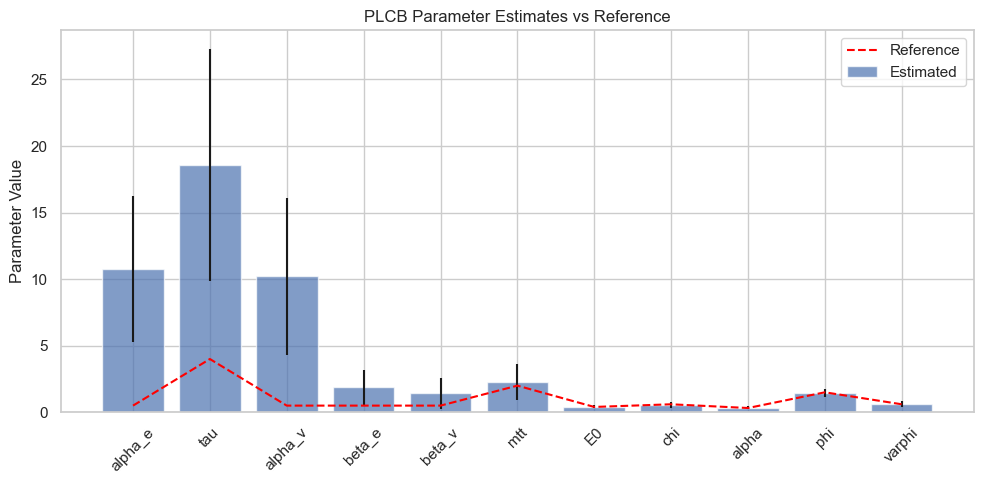

In [3]:
# Plot mean ± std vs reference (PLCB)
plt.figure(figsize=(10, 5))
x = np.arange(len(results_df))
means = results_df["mean"]
stds = results_df["std"]
refs = results_df["reference"]

plt.bar(x, means, yerr=stds, alpha=0.7, label="Estimated")
plt.plot(x, refs, color='red', linestyle='--', label="Reference")
plt.xticks(x, results_df["parameter"], rotation=45)
plt.ylabel("Parameter Value")
plt.title("PLCB Parameter Estimates vs Reference")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

csv_path = "/Users/xuenbei/Desktop/finalyearproject/statistical_tests/pdcm_all_data.csv"
rois = list(range(0, 9))  # LH Visual Network
params = [
    "phi", "varphi", "chi", "mtt", "tau",
    "alpha_v", "beta_v", "alpha_e", "beta_e", "alpha", "E0"
]
reference_values = {
    "phi": 1.5, "varphi": 0.6, "chi": 0.6, "mtt": 2.0, "tau": 4.0,
    "alpha": 0.32, "E0": 0.4, "alpha_v": 0.5, "beta_v": 0.5,
    "alpha_e": 0.5, "beta_e": 0.5
}

df = pd.read_csv(csv_path)

# Filter to PLCB condition and selected ROIs
df = df[(df["experiment"] == "PLCB") & (df["roi"].isin(rois))]

# Pivot to wide format: one row per subject+ROI, one column per parameter
df_wide = df.pivot_table(
    index=["subject", "roi"],
    columns="parameter",
    values="value"
).reset_index()

# Run one-sample t-tests vs reference values 
t_results = []

for param in params:
    values = df_wide[param].dropna()
    ref = reference_values.get(param, 0.0)

    if len(values) < 5:
        continue

    t_stat, p_val = ttest_1samp(values, popmean=ref)

    t_results.append({
        "parameter": param,
        "mean": values.mean(),
        "std": values.std(),
        "reference": ref,
        "t_stat": t_stat,
        "p_value": p_val
    })

results_df = pd.DataFrame(t_results)

# Multiple comparison corrections 
pvals = results_df["p_value"].values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

results_df["p_fdr_bh"] = p_fdr
results_df["reject_fdr_bh"] = rej_fdr
results_df["p_bonferroni"] = p_bonf
results_df["reject_bonferroni"] = rej_bonf
results_df["p_holm"] = p_holm
results_df["reject_holm"] = rej_holm
results_df["reject_raw"] = results_df["p_value"] < 0.05

def interpret_p(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "marginally significant"
    else:
        return "not significant"

def interpret_result(p, mean, ref):
    direction = "↑ above ref" if mean > ref else "↓ below ref"
    return f"{interpret_p(p)}, {direction}"

results_df["interpret_raw"] = results_df.apply(
    lambda row: interpret_result(row["p_value"], row["mean"], row["reference"]), axis=1)
results_df["interpret_fdr_bh"] = results_df.apply(
    lambda row: interpret_result(row["p_fdr_bh"], row["mean"], row["reference"]), axis=1)
results_df["interpret_bonferroni"] = results_df.apply(
    lambda row: interpret_result(row["p_bonferroni"], row["mean"], row["reference"]), axis=1)
results_df["interpret_holm"] = results_df.apply(
    lambda row: interpret_result(row["p_holm"], row["mean"], row["reference"]), axis=1)

results_df = results_df[[
    "parameter", "mean", "std", "reference", "t_stat", "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

results_df.sort_values("p_fdr_bh", inplace=True)

results_df

parameter       mean       std  reference     t_stat       p_value  \
7    alpha_e  10.780890  5.500857       0.50  17.730527  5.926308e-31   
4        tau  18.594201  8.730511       4.00  15.858492  1.146183e-27   
5    alpha_v  10.208197  5.888355       0.50  15.641046  2.841352e-27   
8     beta_e   1.864282  1.289195       0.50  10.039376  2.655352e-16   
6     beta_v   1.410966  1.143042       0.50   7.560686  3.429268e-11   
3        mtt   2.274781  1.341975       2.00   1.942511  5.523692e-02   
10        E0   0.421404  0.123112       0.40   1.649375  1.025962e-01   
2        chi   0.561512  0.233460       0.60  -1.563980  1.213712e-01   
9      alpha   0.335940  0.115964       0.32   1.304040  1.955824e-01   
0        phi   1.470866  0.287523       1.50  -0.961267  3.390223e-01   
1     varphi   0.620389  0.206749       0.60   0.935545  3.520388e-01   

    reject_raw                    interpret_raw      p_fdr_bh  reject_fdr_bh  \
7         True  highly significant, ↑ above ref  6.518939e-30           True   
4         True  highly significant, ↑ above ref  6.304005e-27           True   
5         True  highly significant, ↑ above ref  1.041829e-26           True   
8         True  highly significant, ↑ above ref  7.302217e-16           True   
6         True  highly significant, ↑ above ref  7.544391e-11           True   
3        False     not significant, ↑ above ref  1.012677e-01          False   
10       False     not significant, ↑ above ref  1.612226e-01          False   
2        False     not significant, ↓ below ref  1.668854e-01          False   
9        False     not significant, ↑ above ref  2.390452e-01          False   
0        False     not significant, ↓ below ref  3.520388e-01          False   
1        False     not significant, ↑ above ref  3.520388e-01          False   

                   interpret_fdr_bh  p_bonferroni  reject_bonferroni  \
7   highly significant, ↑ above ref  6.518939e-30               True   
4   highly significant, ↑ above ref  1.260801e-26               True   
5   highly significant, ↑ above ref  3.125487e-26               True   
8   highly significant, ↑ above ref  2.920887e-15               True   
6   highly significant, ↑ above ref  3.772195e-10               True   
3      not significant, ↑ above ref  6.076062e-01              False   
10     not significant, ↑ above ref  1.000000e+00              False   
2      not significant, ↓ below ref  1.000000e+00              False   
9      not significant, ↑ above ref  1.000000e+00              False   
0      not significant, ↓ below ref  1.000000e+00              False   
1      not significant, ↑ above ref  1.000000e+00              False   

               interpret_bonferroni        p_holm  reject_holm  \
7   highly significant, ↑ above ref  6.518939e-30         True   
4   highly significant, ↑ above ref  1.146183e-26         True   
5   highly significant, ↑ above ref  2.557217e-26         True   
8   highly significant, ↑ above ref  2.124281e-15         True   
6   highly significant, ↑ above ref  2.400488e-10         True   
3      not significant, ↑ above ref  3.314215e-01        False   
10     not significant, ↑ above ref  5.129811e-01        False   
2      not significant, ↓ below ref  5.129811e-01        False   
9      not significant, ↑ above ref  5.867473e-01        False   
0      not significant, ↓ below ref  6.780446e-01        False   
1      not significant, ↑ above ref  6.780446e-01        False   

                     interpret_holm  
7   highly significant, ↑ above ref  
4   highly significant, ↑ above ref  
5   highly significant, ↑ above ref  
8   highly significant, ↑ above ref  
6   highly significant, ↑ above ref  
3      not significant, ↑ above ref  
10     not significant, ↑ above ref  
2      not significant, ↓ below ref  
9      not significant, ↑ above ref  
0      not significant, ↓ below ref  
1      not significant, ↑ above ref

## after preprocessing

### PLCB

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

sns.set(style="whitegrid")

df = pd.read_csv("pdcm_all_data.csv")

# Define parameters of interest
params = ["phi", "varphi", "chi", "mtt", "tau", "alpha", "E0", "sigma", "mu", "lamb"]

# Reference values 
reference_values = {
    "phi": 1.5, "varphi": 0.6, "chi": 0.6, "mtt": 2.0, "tau": 4.0, "sigma": 0.5, "mu": 0.4, "lamb": 0.2,
    "alpha": 0.32, "E0": 0.4
}

# Define networks and associated ROI indices
network_rois = {
    "All Regions": list(range(100)),
    "LH Visual": list(range(0, 9)),
    "RH Visual": list(range(50, 58)),
    "LH Somatomotor": list(range(9, 15)),
    "RH Somatomotor": list(range(58, 66)),
    "LH Dorsal Attention": list(range(15, 23)),
    "RH Dorsal Attention": list(range(66, 72)),
    "LH Salience/Ventral Attention": list(range(23, 30)),
    "RH Salience/Ventral Attention": list(range(73, 77)),
    "LH Limbic": list(range(30, 33)),
    "RH Limbic": list(range(78, 80)),
    "LH Control": list(range(33, 37)),
    "RH Control": list(range(80, 88)),
    "LH Default Mode": list(range(37, 50)),
    "RH Default Mode": list(range(89, 100))
}

# Map ROIs to networks
roi_to_network = {}
for net, rois in network_rois.items():
    for roi in rois:
        roi_to_network[roi] = net

df["network"] = df["roi"].map(roi_to_network)

# Group and average per subject/network/condition
agg_df = df[df["parameter"].isin(params)].groupby(
    ["subject", "network", "experiment", "parameter"]
)["value"].mean().reset_index()

# Run one-sample t-tests per (network, parameter)
results = []

for net in agg_df["network"].unique():
    for param in params:
        subdf = agg_df[(agg_df["network"] == net) & (agg_df["parameter"] == param) & (agg_df["experiment"] == "PLCB")]
        if len(subdf) < 5:
            continue  # Skip if too few data points

        values = subdf["value"].dropna()
        ref = reference_values.get(param, 0.0)
        t_stat, p_val = ttest_1samp(values, popmean=ref)

        results.append({
            "network": net,
            "parameter": param,
            "mean": values.mean(),
            "std": values.std(),
            "n": len(values),
            "reference": ref,
            "t_stat": t_stat,
            "p_value": p_val
        })

results_df = pd.DataFrame(results)

# Apply FDR, Bonferroni, Holm
pvals = results_df["p_value"].values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

results_df["p_fdr_bh"] = p_fdr
results_df["reject_fdr_bh"] = rej_fdr
results_df["p_bonferroni"] = p_bonf
results_df["reject_bonferroni"] = rej_bonf
results_df["p_holm"] = p_holm
results_df["reject_holm"] = rej_holm
results_df["reject_raw"] = results_df["p_value"] < 0.05

def interpret_p(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "marginally significant"
    else:
        return "not significant"

def interpret_result(p, mean, ref):
    direction = "↑ above ref" if mean > ref else "↓ below ref"
    return f"{interpret_p(p)}, {direction}"

# Add interpretation
results_df["interpret_raw"] = results_df.apply(
    lambda row: interpret_result(row["p_value"], row["mean"], row["reference"]), axis=1)
results_df["interpret_fdr_bh"] = results_df.apply(
    lambda row: interpret_result(row["p_fdr_bh"], row["mean"], row["reference"]), axis=1)
results_df["interpret_bonferroni"] = results_df.apply(
    lambda row: interpret_result(row["p_bonferroni"], row["mean"], row["reference"]), axis=1)
results_df["interpret_holm"] = results_df.apply(
    lambda row: interpret_result(row["p_holm"], row["mean"], row["reference"]), axis=1)

results_df = results_df[[
    "network", "parameter", "mean", "std", "n", "reference", "t_stat", "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

results_df.sort_values("network", inplace=True)
results_df


network parameter       mean       std   n  reference     t_stat  \
0    All Regions       phi   1.593287  0.191605  10       1.50   1.539617   
1    All Regions    varphi   0.581043  0.089682  10       0.60  -0.668458   
2    All Regions       chi   0.565822  0.146574  10       0.60  -0.737380   
3    All Regions       mtt   2.485045  1.212461  10       2.00   1.265069   
4    All Regions       tau  18.311118  5.612398  10       4.00   8.063528   
..           ...       ...        ...       ...  ..        ...        ...   
144    RH Visual       tau  17.342516  3.360195  10       4.00  12.556635   
145    RH Visual     alpha   0.346645  0.036645  10       0.32   2.299373   
146    RH Visual        E0   0.456024  0.050044  10       0.40   3.540169   
147    RH Visual     sigma   1.005576  0.134838  10       0.50  11.856947   
149    RH Visual      lamb   0.160692  0.035158  10       0.20  -3.535567   

          p_value  reject_raw                        interpret_raw  p_fdr_bh  \
0    1.580388e-01       False         not significant, ↑ above ref  0.257672   
1    5.206151e-01       False         not significant, ↓ below ref  0.624738   
2    4.796733e-01       False         not significant, ↓ below ref  0.589762   
3    2.376184e-01       False         not significant, ↑ above ref  0.330025   
4    2.077819e-05        True      highly significant, ↑ above ref  0.000084   
..            ...         ...                                  ...       ...   
144  5.228140e-07        True      highly significant, ↑ above ref  0.000005   
145  4.704760e-02        True  marginally significant, ↑ above ref  0.096673   
146  6.312435e-03        True             significant, ↑ above ref  0.016444   
147  8.527510e-07        True      highly significant, ↑ above ref  0.000006   
149  6.358161e-03        True             significant, ↓ below ref  0.016444   

     reject_fdr_bh                     interpret_fdr_bh  p_bonferroni  \
0            False         not significant, ↑ above ref      1.000000   
1            False         not significant, ↓ below ref      1.000000   
2            False         not significant, ↓ below ref      1.000000   
3            False         not significant, ↑ above ref      1.000000   
4             True      highly significant, ↑ above ref      0.003117   
..             ...                                  ...           ...   
144           True      highly significant, ↑ above ref      0.000078   
145          False         not significant, ↑ above ref      1.000000   
146           True  marginally significant, ↑ above ref      0.946865   
147           True      highly significant, ↑ above ref      0.000128   
149           True  marginally significant, ↓ below ref      0.953724   

     reject_bonferroni             interpret_bonferroni    p_holm  \
0                False     not significant, ↑ above ref  1.000000   
1                False     not significant, ↓ below ref  1.000000   
2                False     not significant, ↓ below ref  1.000000   
3                False     not significant, ↑ above ref  1.000000   
4                 True         significant, ↑ above ref  0.002369   
..                 ...                              ...       ...   
144               True  highly significant, ↑ above ref  0.000070   
145              False     not significant, ↑ above ref  1.000000   
146              False     not significant, ↑ above ref  0.593369   
147               True  highly significant, ↑ above ref  0.000111   
149              False     not significant, ↓ below ref  0.593369   

     reject_holm                   interpret_holm  
0          False     not significant, ↑ above ref  
1          False     not significant, ↓ below ref  
2          False     not significant, ↓ below ref  
3          False     not significant, ↑ above ref  
4           True         significant, ↑ above ref  
..           ...                              ...  
144         True  highly significant, ↑ above ref  
1

In [ ]:
# Filter rows where raw p-value is not significant
nonsig_df = results_df[results_df["p_value"] >= 0.05].copy()

nonsig_df.sort_values("network", ascending=False, inplace=True)

nonsig_df

network parameter      mean       std   n  reference    t_stat  \
143       RH Visual       mtt  2.180840  0.679329  10       2.00  0.841811   
142       RH Visual       chi  0.569933  0.048600  10       0.60 -1.956410   
141       RH Visual    varphi  0.594872  0.102304  10       0.60 -0.158495   
133  RH Somatomotor       mtt  2.098929  0.576520  10       2.00  0.542638   
136  RH Somatomotor        E0  0.406854  0.040366  10       0.40  0.536933   
..              ...       ...       ...       ...  ..        ...       ...   
2       All Regions       chi  0.565822  0.146574  10       0.60 -0.737380   
1       All Regions    varphi  0.581043  0.089682  10       0.60 -0.668458   
5       All Regions     alpha  0.293131  0.088481  10       0.32 -0.960292   
6       All Regions        E0  0.420637  0.084828  10       0.40  0.769300   
0       All Regions       phi  1.593287  0.191605  10       1.50  1.539617   

      p_value  reject_raw                 interpret_raw  p_fdr_bh  \
143  0.421698       False  not significant, ↑ above ref  0.540639   
142  0.082117       False  not significant, ↓ below ref  0.146637   
141  0.877566       False  not significant, ↓ below ref  0.927006   
133  0.600556       False  not significant, ↑ above ref  0.691983   
136  0.604332       False  not significant, ↑ above ref  0.691983   
..        ...         ...                           ...       ...   
2    0.479673       False  not significant, ↓ below ref  0.589762   
1    0.520615       False  not significant, ↓ below ref  0.624738   
5    0.361995       False  not significant, ↓ below ref  0.472167   
6    0.461427       False  not significant, ↑ above ref  0.572017   
0    0.158039       False  not significant, ↑ above ref  0.257672   

     reject_fdr_bh              interpret_fdr_bh  p_bonferroni  \
143          False  not significant, ↑ above ref           1.0   
142          False  not significant, ↓ below ref           1.0   
141          False  not significant, ↓ below ref           1.0   
133          False  not significant, ↑ above ref           1.0   
136          False  not significant, ↑ above ref           1.0   
..             ...                           ...           ...   
2            False  not significant, ↓ below ref           1.0   
1            False  not significant, ↓ below ref           1.0   
5            False  not significant, ↓ below ref           1.0   
6            False  not significant, ↑ above ref           1.0   
0            False  not significant, ↑ above ref           1.0   

     reject_bonferroni          interpret_bonferroni  p_holm  reject_holm  \
143              False  not significant, ↑ above ref     1.0        False   
142              False  not significant, ↓ below ref     1.0        False   
141              False  not significant, ↓ below ref     1.0        False   
133              False  not significant, ↑ above ref     1.0        False   
136              False  not significant, ↑ above ref     1.0        False   
..                 ...                           ...     ...          ...   
2                False  not significant, ↓ below ref     1.0        False   
1                False  not significant, ↓ below ref     1.0        False   
5                False  not significant, ↓ below ref     1.0        False   
6                False  not significant, ↑ above ref     1.0        False   
0                False  not significant, ↑ above ref     1.0        False   

                   interpret_holm  
143  not significant, ↑ above ref  
142  not significant, ↓ below ref  
141  not significant, ↓ below ref  
133  not significant, ↑ above ref  
136  not significant, ↑ above ref  
..                            ...  
2    not significant, ↓ below ref  
1    not significant, ↓ below ref  
5    not significant, ↓ below ref  
6    not significant, ↑ above ref  
0    not significant, ↑ above ref  

[76 rows x 19 columns]

In [7]:
# FDR BH non-significant
nonsig_fdr = results_df[results_df["reject_fdr_bh"] == False]
nonsig_fdr

network parameter      mean       std   n  reference    t_stat  \
0    All Regions       phi  1.593287  0.191605  10       1.50  1.539617   
1    All Regions    varphi  0.581043  0.089682  10       0.60 -0.668458   
2    All Regions       chi  0.565822  0.146574  10       0.60 -0.737380   
3    All Regions       mtt  2.485045  1.212461  10       2.00  1.265069   
5    All Regions     alpha  0.293131  0.088481  10       0.32 -0.960292   
..           ...       ...       ...       ...  ..        ...       ...   
140    RH Visual       phi  1.569264  0.080108  10       1.50  2.734241   
141    RH Visual    varphi  0.594872  0.102304  10       0.60 -0.158495   
142    RH Visual       chi  0.569933  0.048600  10       0.60 -1.956410   
143    RH Visual       mtt  2.180840  0.679329  10       2.00  0.841811   
145    RH Visual     alpha  0.346645  0.036645  10       0.32  2.299373   

      p_value  reject_raw                        interpret_raw  p_fdr_bh  \
0    0.158039       False         not significant, ↑ above ref  0.257672   
1    0.520615       False         not significant, ↓ below ref  0.624738   
2    0.479673       False         not significant, ↓ below ref  0.589762   
3    0.237618       False         not significant, ↑ above ref  0.330025   
5    0.361995       False         not significant, ↓ below ref  0.472167   
..        ...         ...                                  ...       ...   
140  0.023064        True  marginally significant, ↑ above ref  0.054056   
141  0.877566       False         not significant, ↓ below ref  0.927006   
142  0.082117       False         not significant, ↓ below ref  0.146637   
143  0.421698       False         not significant, ↑ above ref  0.540639   
145  0.047048        True  marginally significant, ↑ above ref  0.096673   

     reject_fdr_bh              interpret_fdr_bh  p_bonferroni  \
0            False  not significant, ↑ above ref           1.0   
1            False  not significant, ↓ below ref           1.0   
2            False  not significant, ↓ below ref           1.0   
3            False  not significant, ↑ above ref           1.0   
5            False  not significant, ↓ below ref           1.0   
..             ...                           ...           ...   
140          False  not significant, ↑ above ref           1.0   
141          False  not significant, ↓ below ref           1.0   
142          False  not significant, ↓ below ref           1.0   
143          False  not significant, ↑ above ref           1.0   
145          False  not significant, ↑ above ref           1.0   

     reject_bonferroni          interpret_bonferroni  p_holm  reject_holm  \
0                False  not significant, ↑ above ref     1.0        False   
1                False  not significant, ↓ below ref     1.0        False   
2                False  not significant, ↓ below ref     1.0        False   
3                False  not significant, ↑ above ref     1.0        False   
5                False  not significant, ↓ below ref     1.0        False   
..                 ...                           ...     ...          ...   
140              False  not significant, ↑ above ref     1.0        False   
141              False  not significant, ↓ below ref     1.0        False   
142              False  not significant, ↓ below ref     1.0        False   
143              False  not significant, ↑ above ref     1.0        False   
145              False  not significant, ↑ above ref     1.0        False   

                   interpret_holm  
0    not significant, ↑ above ref  
1    not significant, ↓ below ref  
2    not significant, ↓ below ref  
3    not significant, ↑ above ref  
5    not significant, ↓ below ref  
..                            ...  
140  not significant, ↑ above ref  
141  not significant, ↓ below ref  
142  not significant, ↓ below ref  
143  not significant, ↑ above ref  
145  not significant, ↑ above ref  

[89 rows x 19 columns]

In [8]:
# Bonferroni non-significant
nonsig_bonf = results_df[results_df["reject_bonferroni"] == False]
nonsig_bonf

network parameter      mean       std   n  reference    t_stat  \
0    All Regions       phi  1.593287  0.191605  10       1.50  1.539617   
1    All Regions    varphi  0.581043  0.089682  10       0.60 -0.668458   
2    All Regions       chi  0.565822  0.146574  10       0.60 -0.737380   
3    All Regions       mtt  2.485045  1.212461  10       2.00  1.265069   
5    All Regions     alpha  0.293131  0.088481  10       0.32 -0.960292   
..           ...       ...       ...       ...  ..        ...       ...   
142    RH Visual       chi  0.569933  0.048600  10       0.60 -1.956410   
143    RH Visual       mtt  2.180840  0.679329  10       2.00  0.841811   
145    RH Visual     alpha  0.346645  0.036645  10       0.32  2.299373   
146    RH Visual        E0  0.456024  0.050044  10       0.40  3.540169   
149    RH Visual      lamb  0.160692  0.035158  10       0.20 -3.535567   

      p_value  reject_raw                        interpret_raw  p_fdr_bh  \
0    0.158039       False         not significant, ↑ above ref  0.257672   
1    0.520615       False         not significant, ↓ below ref  0.624738   
2    0.479673       False         not significant, ↓ below ref  0.589762   
3    0.237618       False         not significant, ↑ above ref  0.330025   
5    0.361995       False         not significant, ↓ below ref  0.472167   
..        ...         ...                                  ...       ...   
142  0.082117       False         not significant, ↓ below ref  0.146637   
143  0.421698       False         not significant, ↑ above ref  0.540639   
145  0.047048        True  marginally significant, ↑ above ref  0.096673   
146  0.006312        True             significant, ↑ above ref  0.016444   
149  0.006358        True             significant, ↓ below ref  0.016444   

     reject_fdr_bh                     interpret_fdr_bh  p_bonferroni  \
0            False         not significant, ↑ above ref      1.000000   
1            False         not significant, ↓ below ref      1.000000   
2            False         not significant, ↓ below ref      1.000000   
3            False         not significant, ↑ above ref      1.000000   
5            False         not significant, ↓ below ref      1.000000   
..             ...                                  ...           ...   
142          False         not significant, ↓ below ref      1.000000   
143          False         not significant, ↑ above ref      1.000000   
145          False         not significant, ↑ above ref      1.000000   
146           True  marginally significant, ↑ above ref      0.946865   
149           True  marginally significant, ↓ below ref      0.953724   

     reject_bonferroni          interpret_bonferroni    p_holm  reject_holm  \
0                False  not significant, ↑ above ref  1.000000        False   
1                False  not significant, ↓ below ref  1.000000        False   
2                False  not significant, ↓ below ref  1.000000        False   
3                False  not significant, ↑ above ref  1.000000        False   
5                False  not significant, ↓ below ref  1.000000        False   
..                 ...                           ...       ...          ...   
142              False  not significant, ↓ below ref  1.000000        False   
143              False  not significant, ↑ above ref  1.000000        False   
145              False  not significant, ↑ above ref  1.000000        False   
146              False  not significant, ↑ above ref  0.593369        False   
149              False  not significant, ↓ below ref  0.593369        False   

                   interpret_holm  
0    not significant, ↑ above ref  
1    not significant, ↓ below ref  
2    not significant, ↓ below ref  
3    not significant, ↑ above ref  
5    not significant, ↓ below ref  
..                            ...  
142  not significant, ↓ below ref  
143  not significant, ↑ above ref  
145  not significant, ↑ above ref  
146  not 

In [9]:

# Holm non-significant
nonsig_holm = results_df[results_df["reject_holm"] == False]
nonsig_holm

network parameter      mean       std   n  reference    t_stat  \
0    All Regions       phi  1.593287  0.191605  10       1.50  1.539617   
1    All Regions    varphi  0.581043  0.089682  10       0.60 -0.668458   
2    All Regions       chi  0.565822  0.146574  10       0.60 -0.737380   
3    All Regions       mtt  2.485045  1.212461  10       2.00  1.265069   
5    All Regions     alpha  0.293131  0.088481  10       0.32 -0.960292   
..           ...       ...       ...       ...  ..        ...       ...   
142    RH Visual       chi  0.569933  0.048600  10       0.60 -1.956410   
143    RH Visual       mtt  2.180840  0.679329  10       2.00  0.841811   
145    RH Visual     alpha  0.346645  0.036645  10       0.32  2.299373   
146    RH Visual        E0  0.456024  0.050044  10       0.40  3.540169   
149    RH Visual      lamb  0.160692  0.035158  10       0.20 -3.535567   

      p_value  reject_raw                        interpret_raw  p_fdr_bh  \
0    0.158039       False         not significant, ↑ above ref  0.257672   
1    0.520615       False         not significant, ↓ below ref  0.624738   
2    0.479673       False         not significant, ↓ below ref  0.589762   
3    0.237618       False         not significant, ↑ above ref  0.330025   
5    0.361995       False         not significant, ↓ below ref  0.472167   
..        ...         ...                                  ...       ...   
142  0.082117       False         not significant, ↓ below ref  0.146637   
143  0.421698       False         not significant, ↑ above ref  0.540639   
145  0.047048        True  marginally significant, ↑ above ref  0.096673   
146  0.006312        True             significant, ↑ above ref  0.016444   
149  0.006358        True             significant, ↓ below ref  0.016444   

     reject_fdr_bh                     interpret_fdr_bh  p_bonferroni  \
0            False         not significant, ↑ above ref      1.000000   
1            False         not significant, ↓ below ref      1.000000   
2            False         not significant, ↓ below ref      1.000000   
3            False         not significant, ↑ above ref      1.000000   
5            False         not significant, ↓ below ref      1.000000   
..             ...                                  ...           ...   
142          False         not significant, ↓ below ref      1.000000   
143          False         not significant, ↑ above ref      1.000000   
145          False         not significant, ↑ above ref      1.000000   
146           True  marginally significant, ↑ above ref      0.946865   
149           True  marginally significant, ↓ below ref      0.953724   

     reject_bonferroni          interpret_bonferroni    p_holm  reject_holm  \
0                False  not significant, ↑ above ref  1.000000        False   
1                False  not significant, ↓ below ref  1.000000        False   
2                False  not significant, ↓ below ref  1.000000        False   
3                False  not significant, ↑ above ref  1.000000        False   
5                False  not significant, ↓ below ref  1.000000        False   
..                 ...                           ...       ...          ...   
142              False  not significant, ↓ below ref  1.000000        False   
143              False  not significant, ↑ above ref  1.000000        False   
145              False  not significant, ↑ above ref  1.000000        False   
146              False  not significant, ↑ above ref  0.593369        False   
149              False  not significant, ↓ below ref  0.593369        False   

                   interpret_holm  
0    not significant, ↑ above ref  
1    not significant, ↓ below ref  
2    not significant, ↓ below ref  
3    not significant, ↑ above ref  
5    not significant, ↓ below ref  
..                            ...  
142  not significant, ↓ below ref  
143  not significant, ↑ above ref  
145  not significant, ↑ above ref  
146  not 

In [ ]:
# Filter where none of the tests show significant difference
consistently_nonsig = results_df[
    (results_df["reject_raw"] == False) &
    (results_df["reject_fdr_bh"] == False) &
    (results_df["reject_bonferroni"] == False) &
    (results_df["reject_holm"] == False)
]

consistently_nonsig = consistently_nonsig.sort_values("network")

consistently_nonsig


network parameter      mean       std   n  reference    t_stat  \
0       All Regions       phi  1.593287  0.191605  10       1.50  1.539617   
1       All Regions    varphi  0.581043  0.089682  10       0.60 -0.668458   
2       All Regions       chi  0.565822  0.146574  10       0.60 -0.737380   
3       All Regions       mtt  2.485045  1.212461  10       2.00  1.265069   
5       All Regions     alpha  0.293131  0.088481  10       0.32 -0.960292   
..              ...       ...       ...       ...  ..        ...       ...   
131  RH Somatomotor    varphi  0.572042  0.069614  10       0.60 -1.269994   
130  RH Somatomotor       phi  1.556672  0.085999  10       1.50  2.083869   
142       RH Visual       chi  0.569933  0.048600  10       0.60 -1.956410   
141       RH Visual    varphi  0.594872  0.102304  10       0.60 -0.158495   
143       RH Visual       mtt  2.180840  0.679329  10       2.00  0.841811   

      p_value  reject_raw                 interpret_raw  p_fdr_bh  \
0    0.158039       False  not significant, ↑ above ref  0.257672   
1    0.520615       False  not significant, ↓ below ref  0.624738   
2    0.479673       False  not significant, ↓ below ref  0.589762   
3    0.237618       False  not significant, ↑ above ref  0.330025   
5    0.361995       False  not significant, ↓ below ref  0.472167   
..        ...         ...                           ...       ...   
131  0.235937       False  not significant, ↓ below ref  0.330025   
130  0.066845       False  not significant, ↑ above ref  0.125334   
142  0.082117       False  not significant, ↓ below ref  0.146637   
141  0.877566       False  not significant, ↓ below ref  0.927006   
143  0.421698       False  not significant, ↑ above ref  0.540639   

     reject_fdr_bh              interpret_fdr_bh  p_bonferroni  \
0            False  not significant, ↑ above ref           1.0   
1            False  not significant, ↓ below ref           1.0   
2            False  not significant, ↓ below ref           1.0   
3            False  not significant, ↑ above ref           1.0   
5            False  not significant, ↓ below ref           1.0   
..             ...                           ...           ...   
131          False  not significant, ↓ below ref           1.0   
130          False  not significant, ↑ above ref           1.0   
142          False  not significant, ↓ below ref           1.0   
141          False  not significant, ↓ below ref           1.0   
143          False  not significant, ↑ above ref           1.0   

     reject_bonferroni          interpret_bonferroni  p_holm  reject_holm  \
0                False  not significant, ↑ above ref     1.0        False   
1                False  not significant, ↓ below ref     1.0        False   
2                False  not significant, ↓ below ref     1.0        False   
3                False  not significant, ↑ above ref     1.0        False   
5                False  not significant, ↓ below ref     1.0        False   
..                 ...                           ...     ...          ...   
131              False  not significant, ↓ below ref     1.0        False   
130              False  not significant, ↑ above ref     1.0        False   
142              False  not significant, ↓ below ref     1.0        False   
141              False  not significant, ↓ below ref     1.0        False   
143              False  not significant, ↑ above ref     1.0        False   

                   interpret_holm  
0    not significant, ↑ above ref  
1    not significant, ↓ below ref  
2    not significant, ↓ below ref  
3    not significant, ↑ above ref  
5    not significant, ↓ below ref  
..                            ...  
131  not significant, ↓ below ref  
130  not significant, ↑ above ref  
142  not significant, ↓ below ref  
141  not significant, ↓ below ref  
143  not significant, ↑ above ref  

[76 rows x 19 columns]

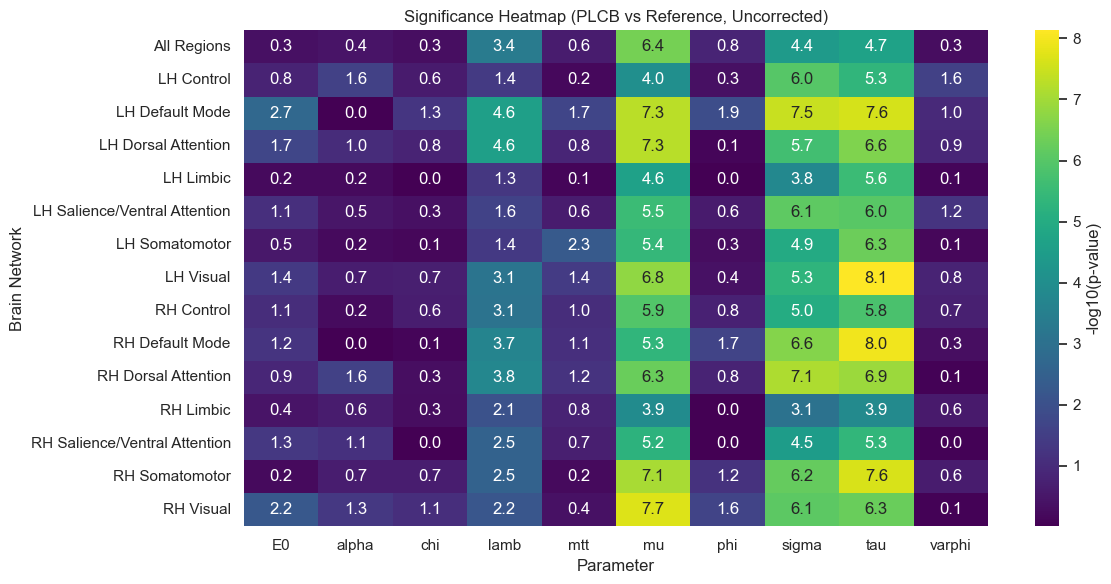

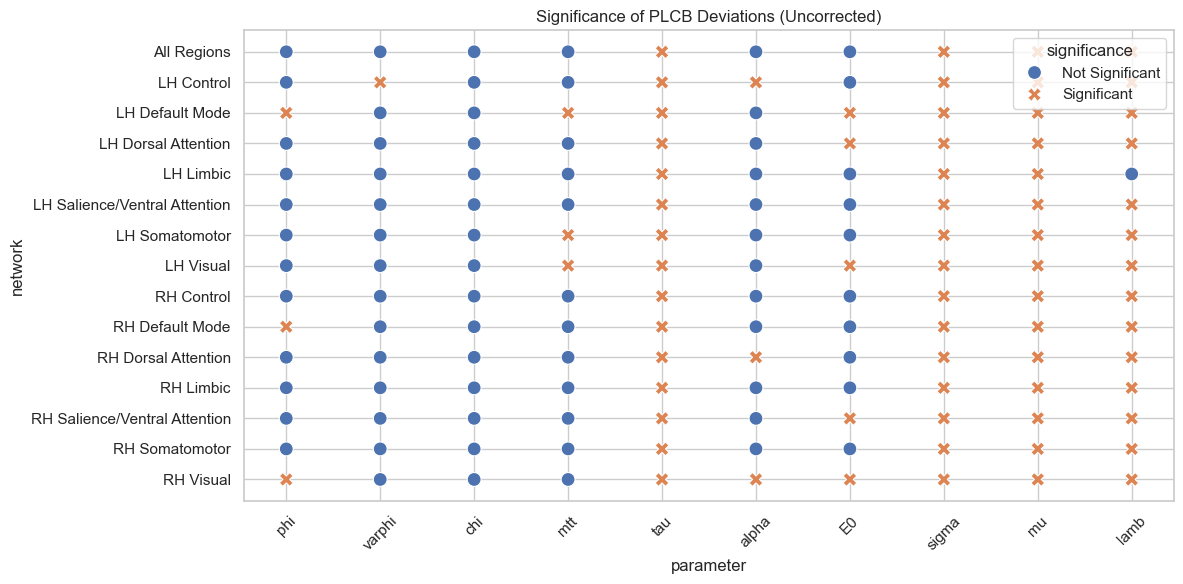

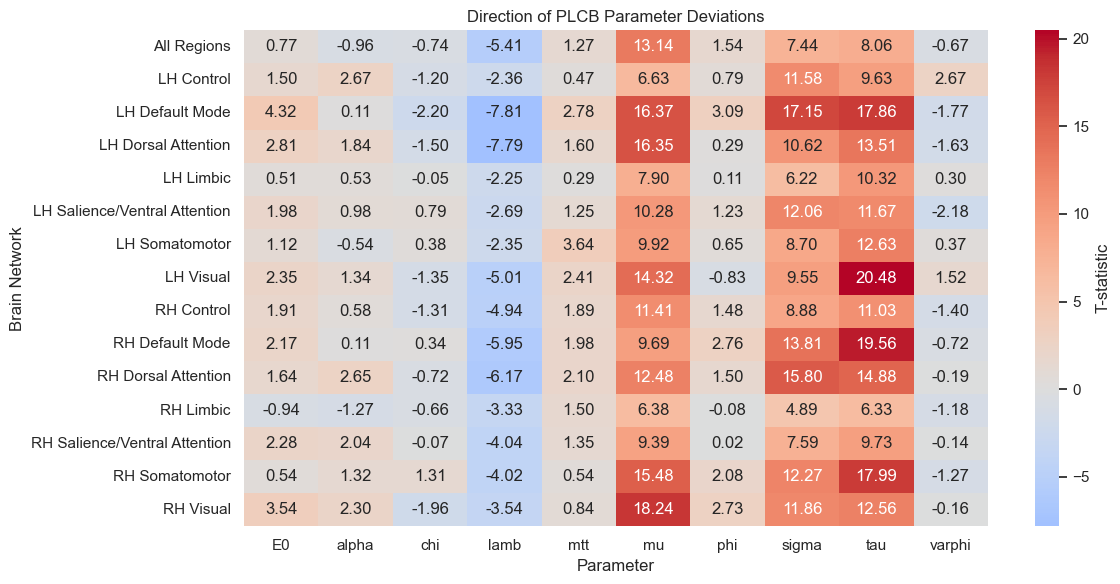

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df.pivot(index="network", columns="parameter", values="p_value")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs Reference, Uncorrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df["significance"] = results_df["reject_raw"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
# −log10(p-value) < 1.3 suggests non-significance at the p = 0.05 level.

plt.title("Significance of PLCB Deviations (Uncorrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

heatmap_vals = results_df.copy()

heatmap_matrix = heatmap_vals.pivot(index="network", columns="parameter", values="t_stat")

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_matrix,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "T-statistic"}
)
plt.title("Direction of PLCB Parameter Deviations")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()




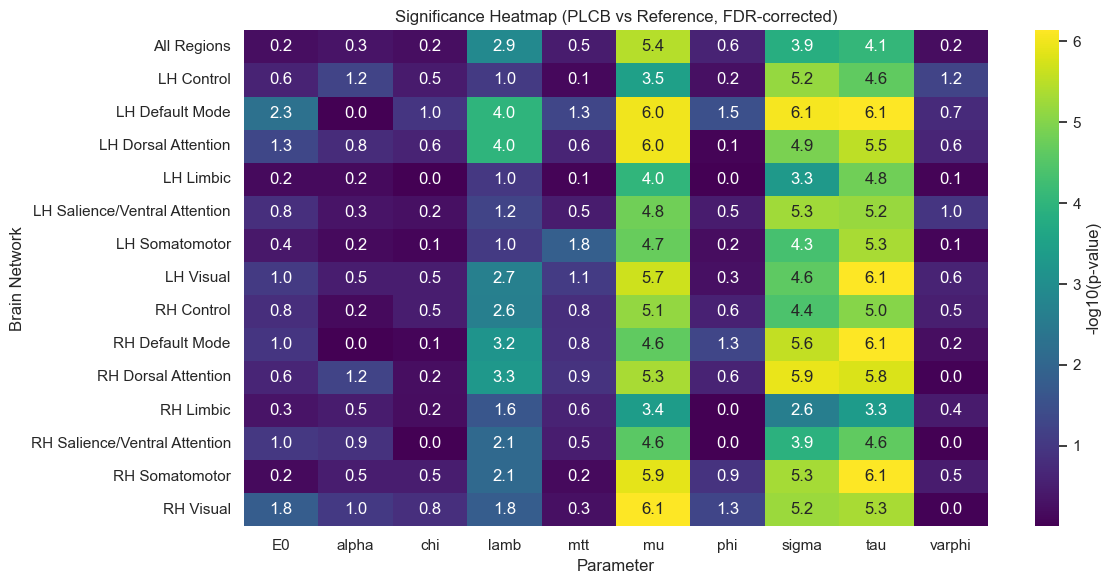

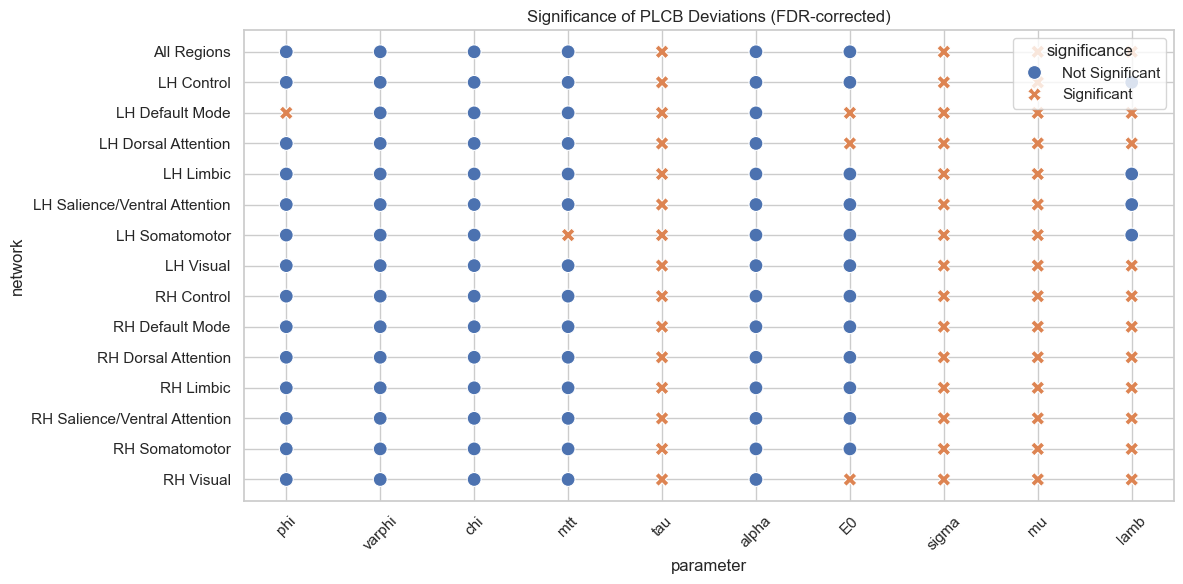

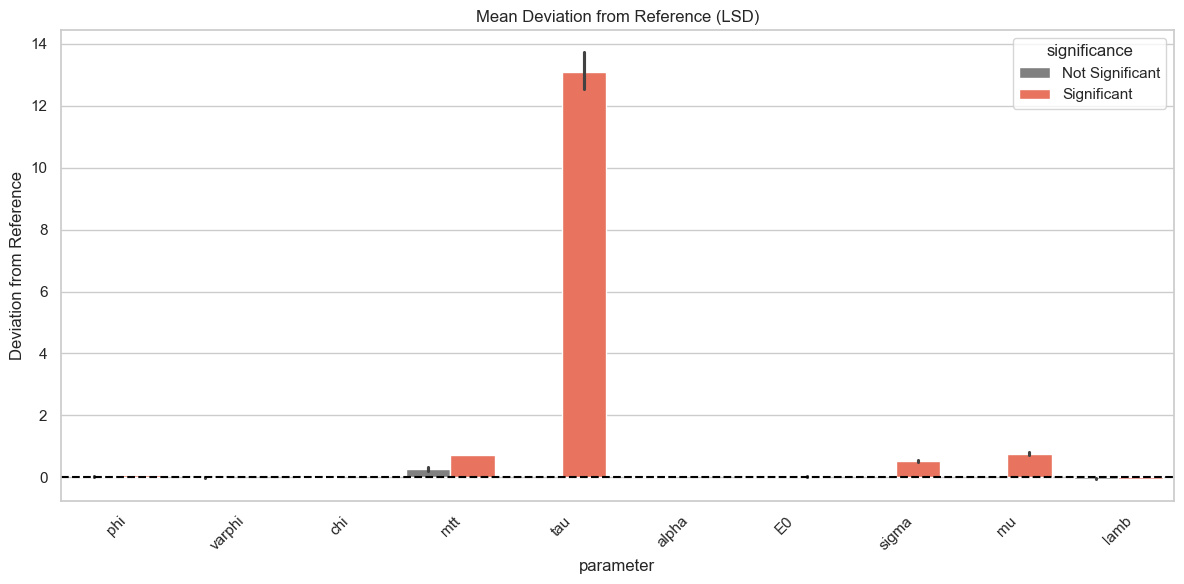

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df.pivot(index="network", columns="parameter", values="p_fdr_bh")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs Reference, FDR-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df["significance"] = results_df["reject_fdr_bh"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of PLCB Deviations (FDR-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df["mean_diff"] = results_df["mean"] - results_df["reference"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df, x="parameter", y="mean_diff", hue="significance",
    palette={"Significant": "tomato", "Not Significant": "gray"}
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Mean Deviation from Reference (LSD)")
plt.ylabel("Deviation from Reference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


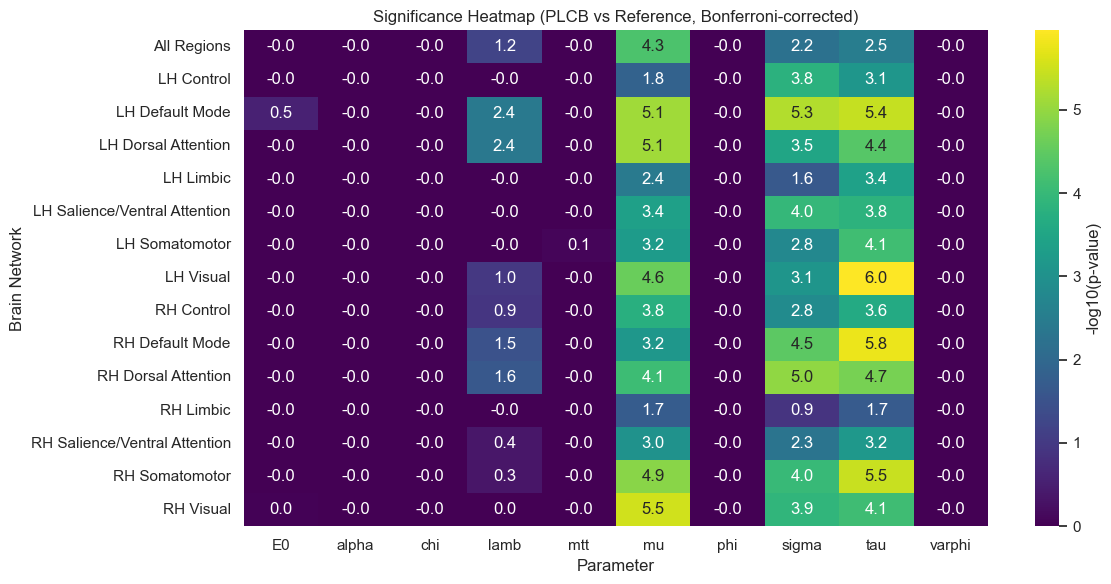

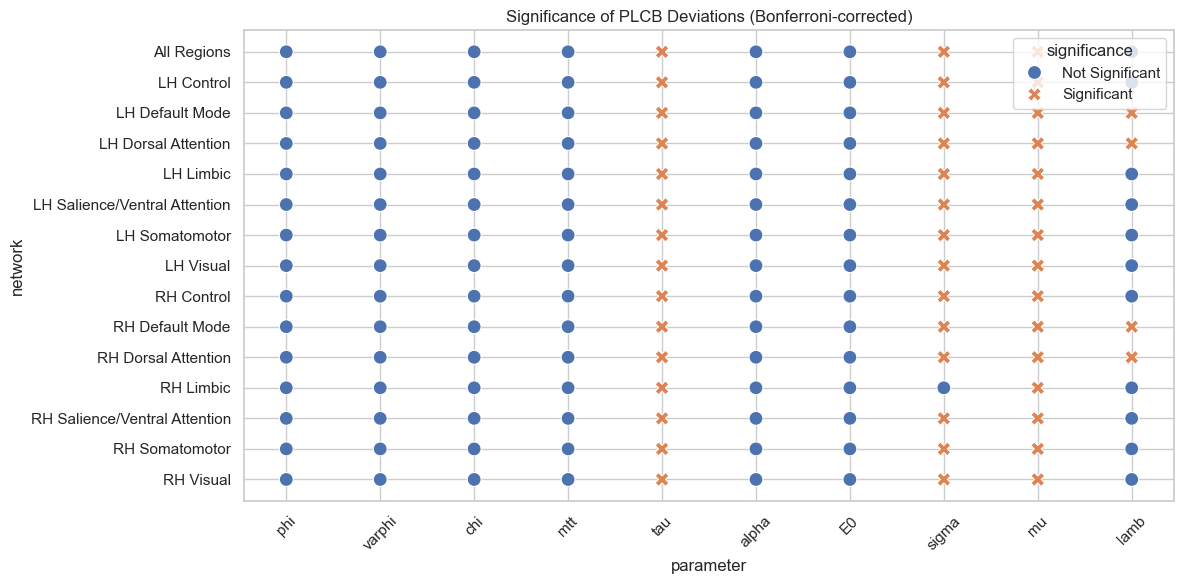

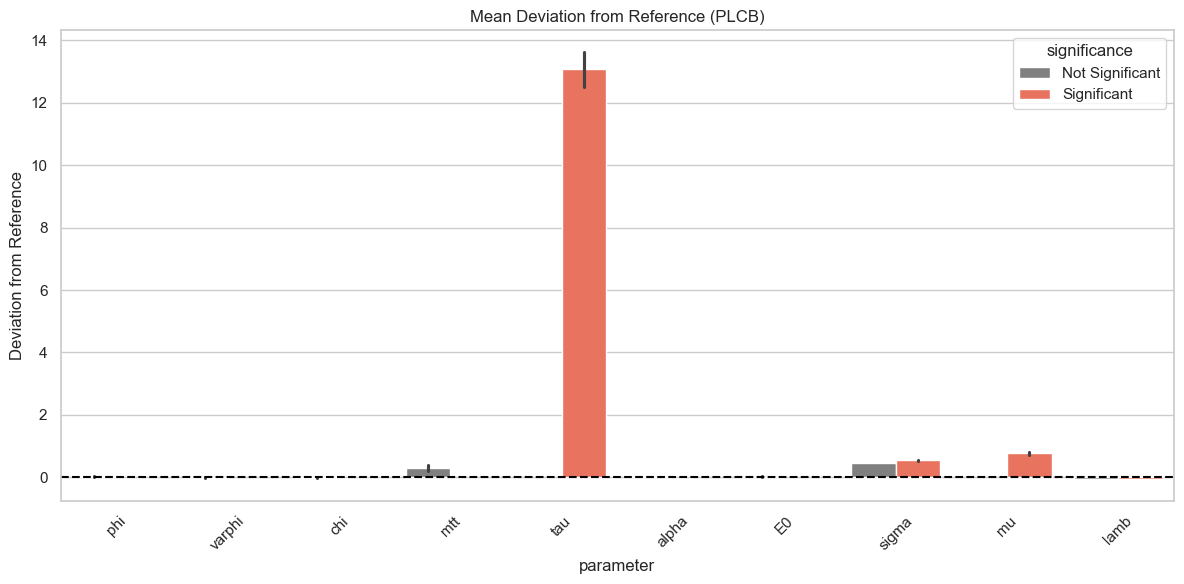

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df.pivot(index="network", columns="parameter", values="p_bonferroni")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs Reference, Bonferroni-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df["significance"] = results_df["reject_bonferroni"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of PLCB Deviations (Bonferroni-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df["mean_diff"] = results_df["mean"] - results_df["reference"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df, x="parameter", y="mean_diff", hue="significance",
    palette={"Significant": "tomato", "Not Significant": "gray"}
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Mean Deviation from Reference (PLCB)")
plt.ylabel("Deviation from Reference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


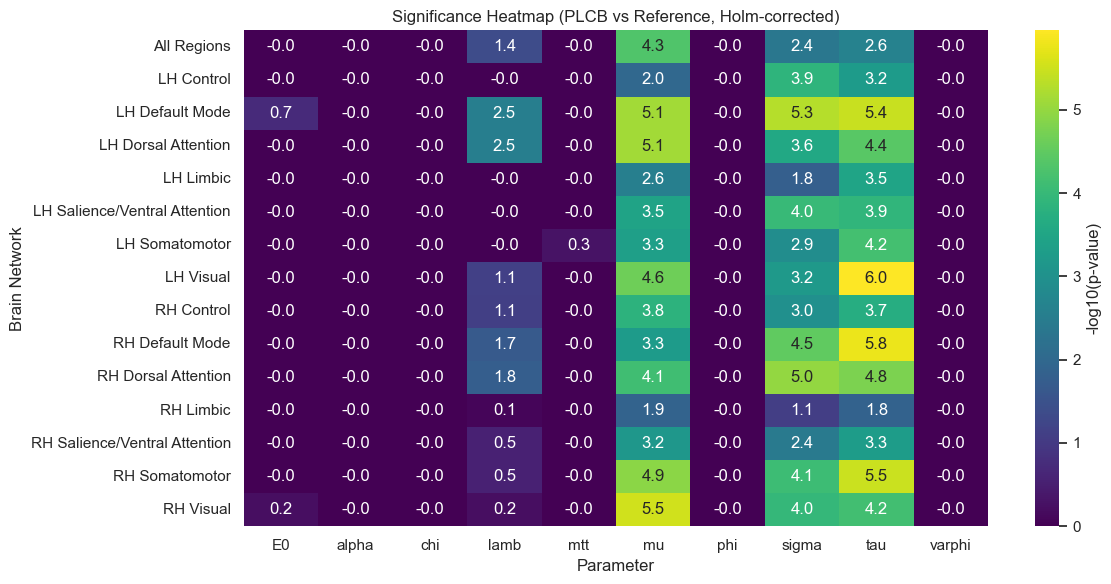

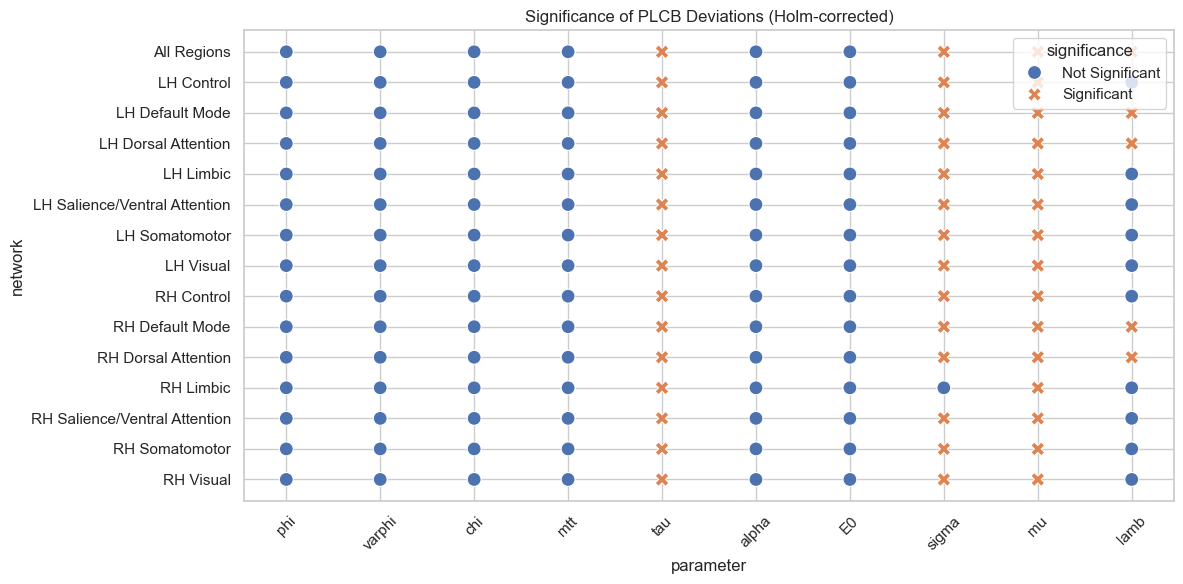

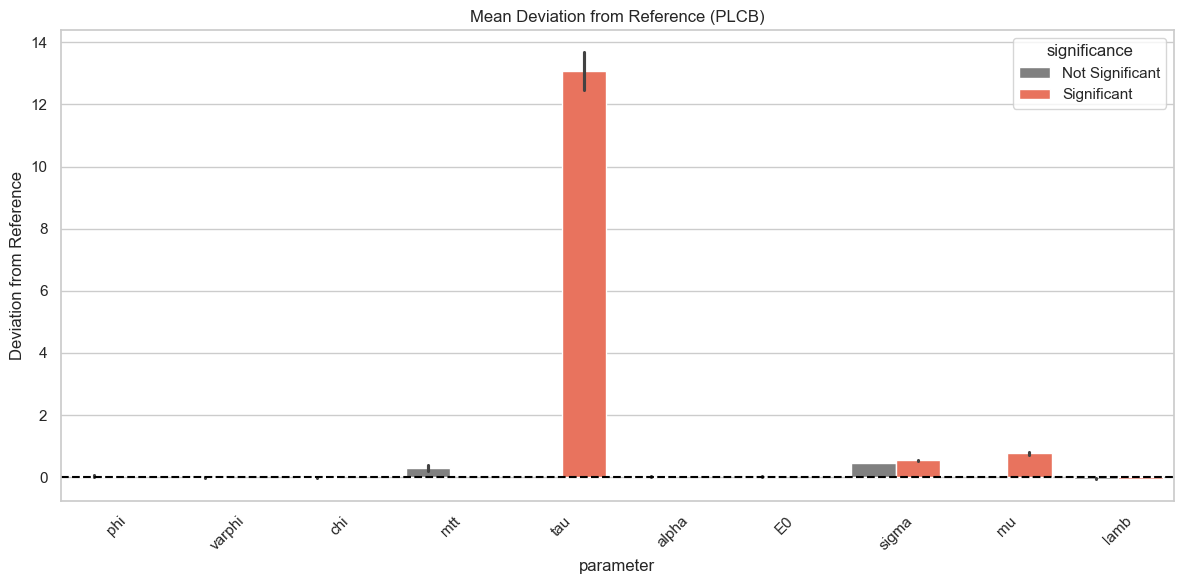

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df.pivot(index="network", columns="parameter", values="p_holm")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (PLCB vs Reference, Holm-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df["significance"] = results_df["reject_holm"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of PLCB Deviations (Holm-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df["mean_diff"] = results_df["mean"] - results_df["reference"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df, x="parameter", y="mean_diff", hue="significance",
    palette={"Significant": "tomato", "Not Significant": "gray"}
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Mean Deviation from Reference (PLCB)")
plt.ylabel("Deviation from Reference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


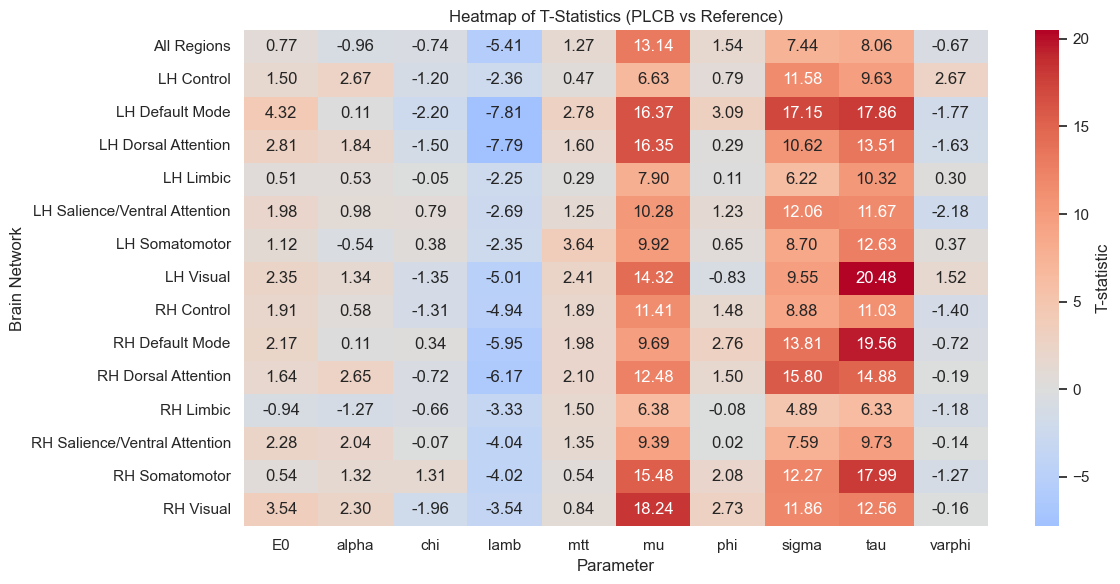

In [15]:
# Pivot t-statistics for heatmap
tstat_heatmap_df = results_df.pivot(index="network", columns="parameter", values="t_stat")

plt.figure(figsize=(12, 6))
sns.heatmap(
    tstat_heatmap_df,
    cmap="coolwarm", center=0,
    annot=True, fmt=".2f",
    cbar_kws={"label": "T-statistic"}
)
plt.title("Heatmap of T-Statistics (PLCB vs Reference)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()


### LSD

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

sns.set(style="whitegrid")

df = pd.read_csv("/Users/xuenbei/Desktop/finalyearproject/statistical_tests/pdcm_all_data.csv")

# Define parameters of interest
params = ["phi", "varphi", "chi", "mtt", "tau", "alpha", "E0", "sigma", "mu", "lamb"]

# Reference values 
reference_values = {
    "phi": 1.5, "varphi": 0.6, "chi": 0.6, "mtt": 2.0, "tau": 4.0, "sigma": 0.5, "mu": 0.4, "lamb": 0.2,
    "alpha": 0.32, "E0": 0.4
}


# Define networks and associated ROI indices
network_rois = {
    "All Regions": list(range(100)),
    "LH Visual": list(range(0, 9)),
    "RH Visual": list(range(50, 58)),
    "LH Somatomotor": list(range(9, 15)),
    "RH Somatomotor": list(range(58, 66)),
    "LH Dorsal Attention": list(range(15, 23)),
    "RH Dorsal Attention": list(range(66, 72)),
    "LH Salience/Ventral Attention": list(range(23, 30)),
    "RH Salience/Ventral Attention": list(range(73, 77)),
    "LH Limbic": list(range(30, 33)),
    "RH Limbic": list(range(78, 80)),
    "LH Control": list(range(33, 37)),
    "RH Control": list(range(80, 88)),
    "LH Default Mode": list(range(37, 50)),
    "RH Default Mode": list(range(89, 100))
}

# Map ROIs to networks
roi_to_network = {}
for net, rois in network_rois.items():
    for roi in rois:
        roi_to_network[roi] = net

df["network"] = df["roi"].map(roi_to_network)

# Group and average per subject/network/condition
agg_df = df[df["parameter"].isin(params)].groupby(
    ["subject", "network", "experiment", "parameter"]
)["value"].mean().reset_index()

# Run one-sample t-tests per (network, parameter)
results = []

for net in agg_df["network"].unique():
    for param in params:
        subdf = agg_df[(agg_df["network"] == net) & (agg_df["parameter"] == param) & (agg_df["experiment"] == "LSD")]
        if len(subdf) < 5:
            continue  # Skip if too few data points

        values = subdf["value"].dropna()
        ref = reference_values.get(param, 0.0)
        t_stat, p_val = ttest_1samp(values, popmean=ref)

        results.append({
            "network": net,
            "parameter": param,
            "mean": values.mean(),
            "std": values.std(),
            "n": len(values),
            "reference": ref,
            "t_stat": t_stat,
            "p_value": p_val
        })

results_df_lsd = pd.DataFrame(results)

# Apply FDR, Bonferroni, Holm
pvals = results_df_lsd["p_value"].values
rej_fdr, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
rej_bonf, p_bonf, _, _ = multipletests(pvals, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(pvals, method="holm")

results_df_lsd["p_fdr_bh"] = p_fdr
results_df_lsd["reject_fdr_bh"] = rej_fdr
results_df_lsd["p_bonferroni"] = p_bonf
results_df_lsd["reject_bonferroni"] = rej_bonf
results_df_lsd["p_holm"] = p_holm
results_df_lsd["reject_holm"] = rej_holm
results_df_lsd["reject_raw"] = results_df_lsd["p_value"] < 0.05

def interpret_p(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "marginally significant"
    else:
        return "not significant"

def interpret_result(p, mean, ref):
    direction = "↑ above ref" if mean > ref else "↓ below ref"
    return f"{interpret_p(p)}, {direction}"

# Add interpretation
results_df_lsd["interpret_raw"] = results_df_lsd.apply(
    lambda row: interpret_result(row["p_value"], row["mean"], row["reference"]), axis=1)
results_df_lsd["interpret_fdr_bh"] = results_df_lsd.apply(
    lambda row: interpret_result(row["p_fdr_bh"], row["mean"], row["reference"]), axis=1)
results_df_lsd["interpret_bonferroni"] = results_df_lsd.apply(
    lambda row: interpret_result(row["p_bonferroni"], row["mean"], row["reference"]), axis=1)
results_df_lsd["interpret_holm"] = results_df_lsd.apply(
    lambda row: interpret_result(row["p_holm"], row["mean"], row["reference"]), axis=1)

# Order columns and sort
results_df_lsd = results_df_lsd[[
    "network", "parameter", "mean", "std", "n", "reference", "t_stat", "p_value", "reject_raw", "interpret_raw",
    "p_fdr_bh", "reject_fdr_bh", "interpret_fdr_bh",
    "p_bonferroni", "reject_bonferroni", "interpret_bonferroni",
    "p_holm", "reject_holm", "interpret_holm"
]]

results_df_lsd.sort_values("network", inplace=True)
results_df_lsd


network parameter       mean       std   n  reference     t_stat  \
0    All Regions       phi   1.544729  0.169214  10       1.50   0.835909   
1    All Regions    varphi   0.624369  0.169566  10       0.60   0.454467   
2    All Regions       chi   0.640149  0.184801  10       0.60   0.687022   
3    All Regions       mtt   2.295231  0.816891  10       2.00   1.142872   
4    All Regions       tau  19.573892  4.351845  10       4.00  11.316802   
..           ...       ...        ...       ...  ..        ...        ...   
144    RH Visual       tau  16.775669  1.785915  10       4.00  22.621576   
145    RH Visual     alpha   0.355551  0.025188  10       0.32   4.463301   
146    RH Visual        E0   0.409993  0.049321  10       0.40   0.640684   
147    RH Visual     sigma   1.113983  0.139417  10       0.50  13.926440   
149    RH Visual      lamb   0.116852  0.016438  10       0.20 -15.995732   

          p_value  reject_raw                    interpret_raw      p_fdr_bh  \
0    4.248418e-01       False     not significant, ↑ above ref  5.180997e-01   
1    6.602549e-01       False     not significant, ↑ above ref  7.125053e-01   
2    5.093827e-01       False     not significant, ↑ above ref  5.923054e-01   
3    2.825817e-01       False     not significant, ↑ above ref  4.103598e-01   
4    1.266597e-06        True  highly significant, ↑ above ref  7.036648e-06   
..            ...         ...                              ...           ...   
144  3.056232e-09        True  highly significant, ↑ above ref  1.528116e-07   
145  1.569760e-03        True         significant, ↑ above ref  4.360445e-03   
146  5.376970e-01       False     not significant, ↑ above ref  6.204197e-01   
147  2.146319e-07        True  highly significant, ↑ above ref  2.682899e-06   
149  6.447612e-08        True  highly significant, ↓ below ref  1.381631e-06   

     reject_fdr_bh                 interpret_fdr_bh  p_bonferroni  \
0            False     not significant, ↑ above ref  1.000000e+00   
1            False     not significant, ↑ above ref  1.000000e+00   
2            False     not significant, ↑ above ref  1.000000e+00   
3            False     not significant, ↑ above ref  1.000000e+00   
4             True  highly significant, ↑ above ref  1.899895e-04   
..             ...                              ...           ...   
144           True  highly significant, ↑ above ref  4.584349e-07   
145           True         significant, ↑ above ref  2.354640e-01   
146          False     not significant, ↑ above ref  1.000000e+00   
147           True  highly significant, ↑ above ref  3.219479e-05   
149           True  highly significant, ↓ below ref  9.671418e-06   

     reject_bonferroni             interpret_bonferroni        p_holm  \
0                False     not significant, ↑ above ref  1.000000e+00   
1                False     not significant, ↑ above ref  1.000000e+00   
2                False     not significant, ↑ above ref  1.000000e+00   
3                False     not significant, ↑ above ref  1.000000e+00   
4                 True  highly significant, ↑ above ref  1.570580e-04   
..                 ...                              ...           ...   
144               True  highly significant, ↑ above ref  4.523224e-07   
145              False     not significant, ↑ above ref  1.522667e-01   
146              False     not significant, ↑ above ref  1.000000e+00   
147               True  highly significant, ↑ above ref  2.983384e-05   
149               True  highly significant, ↓ below ref  9.284562e-06   

     reject_holm                   interpret_holm  
0          False     not significant, ↑ above ref  
1          False     not significant, ↑ above ref  
2          False     not significant, ↑ above ref  
3          False     not significant, ↑ above ref  
4           True  highly significant, ↑ above ref  
..           ...                              ...  
144         True  highly significant, ↑ above ref  
1

In [17]:
# Filter rows where raw p-value is not significant
nonsig_df_lsd = results_df_lsd[results_df_lsd["p_value"] >= 0.05].copy()

# Optional: sort for easier inspection
nonsig_df_lsd.sort_values("network", ascending=False, inplace=True)

# Display or export
nonsig_df_lsd

network parameter      mean       std   n  reference    t_stat  \
146       RH Visual        E0  0.409993  0.049321  10       0.40  0.640684   
142       RH Visual       chi  0.640495  0.095076  10       0.60  1.346881   
141       RH Visual    varphi  0.625023  0.095784  10       0.60  0.826116   
140       RH Visual       phi  1.468677  0.091150  10       1.50 -1.086700   
132  RH Somatomotor       chi  0.625129  0.087980  10       0.60  0.903198   
..              ...       ...       ...       ...  ..        ...       ...   
2       All Regions       chi  0.640149  0.184801  10       0.60  0.687022   
1       All Regions    varphi  0.624369  0.169566  10       0.60  0.454467   
5       All Regions     alpha  0.342837  0.056400  10       0.32  1.280445   
6       All Regions        E0  0.400036  0.048481  10       0.40  0.002355   
0       All Regions       phi  1.544729  0.169214  10       1.50  0.835909   

      p_value  reject_raw                 interpret_raw  p_fdr_bh  \
146  0.537697       False  not significant, ↑ above ref  0.620420   
142  0.210951       False  not significant, ↑ above ref  0.336624   
141  0.430093       False  not significant, ↑ above ref  0.520274   
140  0.305415       False  not significant, ↓ below ref  0.428153   
132  0.389954       False  not significant, ↑ above ref  0.498522   
..        ...         ...                           ...       ...   
2    0.509383       False  not significant, ↑ above ref  0.592305   
1    0.660255       False  not significant, ↑ above ref  0.712505   
5    0.232402       False  not significant, ↑ above ref  0.359385   
6    0.998172       False  not significant, ↑ above ref  0.998172   
0    0.424842       False  not significant, ↑ above ref  0.518100   

     reject_fdr_bh              interpret_fdr_bh  p_bonferroni  \
146          False  not significant, ↑ above ref           1.0   
142          False  not significant, ↑ above ref           1.0   
141          False  not significant, ↑ above ref           1.0   
140          False  not significant, ↓ below ref           1.0   
132          False  not significant, ↑ above ref           1.0   
..             ...                           ...           ...   
2            False  not significant, ↑ above ref           1.0   
1            False  not significant, ↑ above ref           1.0   
5            False  not significant, ↑ above ref           1.0   
6            False  not significant, ↑ above ref           1.0   
0            False  not significant, ↑ above ref           1.0   

     reject_bonferroni          interpret_bonferroni  p_holm  reject_holm  \
146              False  not significant, ↑ above ref     1.0        False   
142              False  not significant, ↑ above ref     1.0        False   
141              False  not significant, ↑ above ref     1.0        False   
140              False  not significant, ↓ below ref     1.0        False   
132              False  not significant, ↑ above ref     1.0        False   
..                 ...                           ...     ...          ...   
2                False  not significant, ↑ above ref     1.0        False   
1                False  not significant, ↑ above ref     1.0        False   
5                False  not significant, ↑ above ref     1.0        False   
6                False  not significant, ↑ above ref     1.0        False   
0                False  not significant, ↑ above ref     1.0        False   

                   interpret_holm  
146  not significant, ↑ above ref  
142  not significant, ↑ above ref  
141  not significant, ↑ above ref  
140  not significant, ↓ below ref  
132  not significant, ↑ above ref  
..                            ...  
2    not significant, ↑ above ref  
1    not significant, ↑ above ref  
5    not significant, ↑ above ref  
6    not significant, ↑ above ref  
0    not significant, ↑ above ref  

[77 rows x 19 columns]

In [18]:
# Bonferroni non-significant
nonsig_bonf_lsd = results_df_lsd[results_df_lsd["reject_bonferroni"] == False]
nonsig_bonf_lsd

network parameter      mean       std   n  reference    t_stat  \
0    All Regions       phi  1.544729  0.169214  10       1.50  0.835909   
1    All Regions    varphi  0.624369  0.169566  10       0.60  0.454467   
2    All Regions       chi  0.640149  0.184801  10       0.60  0.687022   
3    All Regions       mtt  2.295231  0.816891  10       2.00  1.142872   
5    All Regions     alpha  0.342837  0.056400  10       0.32  1.280445   
..           ...       ...       ...       ...  ..        ...       ...   
141    RH Visual    varphi  0.625023  0.095784  10       0.60  0.826116   
142    RH Visual       chi  0.640495  0.095076  10       0.60  1.346881   
143    RH Visual       mtt  2.291876  0.406331  10       2.00  2.271533   
145    RH Visual     alpha  0.355551  0.025188  10       0.32  4.463301   
146    RH Visual        E0  0.409993  0.049321  10       0.40  0.640684   

      p_value  reject_raw                        interpret_raw  p_fdr_bh  \
0    0.424842       False         not significant, ↑ above ref  0.518100   
1    0.660255       False         not significant, ↑ above ref  0.712505   
2    0.509383       False         not significant, ↑ above ref  0.592305   
3    0.282582       False         not significant, ↑ above ref  0.410360   
5    0.232402       False         not significant, ↑ above ref  0.359385   
..        ...         ...                                  ...       ...   
141  0.430093       False         not significant, ↑ above ref  0.520274   
142  0.210951       False         not significant, ↑ above ref  0.336624   
143  0.049240        True  marginally significant, ↑ above ref  0.101177   
145  0.001570        True             significant, ↑ above ref  0.004360   
146  0.537697       False         not significant, ↑ above ref  0.620420   

     reject_fdr_bh              interpret_fdr_bh  p_bonferroni  \
0            False  not significant, ↑ above ref      1.000000   
1            False  not significant, ↑ above ref      1.000000   
2            False  not significant, ↑ above ref      1.000000   
3            False  not significant, ↑ above ref      1.000000   
5            False  not significant, ↑ above ref      1.000000   
..             ...                           ...           ...   
141          False  not significant, ↑ above ref      1.000000   
142          False  not significant, ↑ above ref      1.000000   
143          False  not significant, ↑ above ref      1.000000   
145           True      significant, ↑ above ref      0.235464   
146          False  not significant, ↑ above ref      1.000000   

     reject_bonferroni          interpret_bonferroni    p_holm  reject_holm  \
0                False  not significant, ↑ above ref  1.000000        False   
1                False  not significant, ↑ above ref  1.000000        False   
2                False  not significant, ↑ above ref  1.000000        False   
3                False  not significant, ↑ above ref  1.000000        False   
5                False  not significant, ↑ above ref  1.000000        False   
..                 ...                           ...       ...          ...   
141              False  not significant, ↑ above ref  1.000000        False   
142              False  not significant, ↑ above ref  1.000000        False   
143              False  not significant, ↑ above ref  1.000000        False   
145              False  not significant, ↑ above ref  0.152267        False   
146              False  not significant, ↑ above ref  1.000000        False   

                   interpret_holm  
0    not significant, ↑ above ref  
1    not significant, ↑ above ref  
2    not significant, ↑ above ref  
3    not significant, ↑ above ref  
5    not significant, ↑ above ref  
..                            ...  
141  not significant, ↑ above ref  
142  not significant, ↑ above ref  
143  not significant, ↑ above ref  
145  not significant, ↑ above ref  
146  not significant, ↑ above ref  

[106 rows x 19 colum

In [19]:
# Holm non-significant
nonsig_holm_lsd = results_df_lsd[results_df_lsd["reject_holm"] == False]
nonsig_holm_lsd

network parameter      mean       std   n  reference    t_stat  \
0    All Regions       phi  1.544729  0.169214  10       1.50  0.835909   
1    All Regions    varphi  0.624369  0.169566  10       0.60  0.454467   
2    All Regions       chi  0.640149  0.184801  10       0.60  0.687022   
3    All Regions       mtt  2.295231  0.816891  10       2.00  1.142872   
5    All Regions     alpha  0.342837  0.056400  10       0.32  1.280445   
..           ...       ...       ...       ...  ..        ...       ...   
141    RH Visual    varphi  0.625023  0.095784  10       0.60  0.826116   
142    RH Visual       chi  0.640495  0.095076  10       0.60  1.346881   
143    RH Visual       mtt  2.291876  0.406331  10       2.00  2.271533   
145    RH Visual     alpha  0.355551  0.025188  10       0.32  4.463301   
146    RH Visual        E0  0.409993  0.049321  10       0.40  0.640684   

      p_value  reject_raw                        interpret_raw  p_fdr_bh  \
0    0.424842       False         not significant, ↑ above ref  0.518100   
1    0.660255       False         not significant, ↑ above ref  0.712505   
2    0.509383       False         not significant, ↑ above ref  0.592305   
3    0.282582       False         not significant, ↑ above ref  0.410360   
5    0.232402       False         not significant, ↑ above ref  0.359385   
..        ...         ...                                  ...       ...   
141  0.430093       False         not significant, ↑ above ref  0.520274   
142  0.210951       False         not significant, ↑ above ref  0.336624   
143  0.049240        True  marginally significant, ↑ above ref  0.101177   
145  0.001570        True             significant, ↑ above ref  0.004360   
146  0.537697       False         not significant, ↑ above ref  0.620420   

     reject_fdr_bh              interpret_fdr_bh  p_bonferroni  \
0            False  not significant, ↑ above ref      1.000000   
1            False  not significant, ↑ above ref      1.000000   
2            False  not significant, ↑ above ref      1.000000   
3            False  not significant, ↑ above ref      1.000000   
5            False  not significant, ↑ above ref      1.000000   
..             ...                           ...           ...   
141          False  not significant, ↑ above ref      1.000000   
142          False  not significant, ↑ above ref      1.000000   
143          False  not significant, ↑ above ref      1.000000   
145           True      significant, ↑ above ref      0.235464   
146          False  not significant, ↑ above ref      1.000000   

     reject_bonferroni          interpret_bonferroni    p_holm  reject_holm  \
0                False  not significant, ↑ above ref  1.000000        False   
1                False  not significant, ↑ above ref  1.000000        False   
2                False  not significant, ↑ above ref  1.000000        False   
3                False  not significant, ↑ above ref  1.000000        False   
5                False  not significant, ↑ above ref  1.000000        False   
..                 ...                           ...       ...          ...   
141              False  not significant, ↑ above ref  1.000000        False   
142              False  not significant, ↑ above ref  1.000000        False   
143              False  not significant, ↑ above ref  1.000000        False   
145              False  not significant, ↑ above ref  0.152267        False   
146              False  not significant, ↑ above ref  1.000000        False   

                   interpret_holm  
0    not significant, ↑ above ref  
1    not significant, ↑ above ref  
2    not significant, ↑ above ref  
3    not significant, ↑ above ref  
5    not significant, ↑ above ref  
..                            ...  
141  not significant, ↑ above ref  
142  not significant, ↑ above ref  
143  not significant, ↑ above ref  
145  not significant, ↑ above ref  
146  not significant, ↑ above ref  

[104 rows x 19 colum

In [20]:
# Filter where none of the tests show significant difference
consistently_nonsig_lsd = results_df_lsd[
    (results_df_lsd["reject_raw"] == False) &
    (results_df_lsd["reject_fdr_bh"] == False) &
    (results_df_lsd["reject_bonferroni"] == False) &
    (results_df_lsd["reject_holm"] == False)
]

consistently_nonsig_lsd = consistently_nonsig_lsd.sort_values("network")

consistently_nonsig_lsd


network parameter      mean       std   n  reference    t_stat  \
0       All Regions       phi  1.544729  0.169214  10       1.50  0.835909   
1       All Regions    varphi  0.624369  0.169566  10       0.60  0.454467   
2       All Regions       chi  0.640149  0.184801  10       0.60  0.687022   
3       All Regions       mtt  2.295231  0.816891  10       2.00  1.142872   
5       All Regions     alpha  0.342837  0.056400  10       0.32  1.280445   
..              ...       ...       ...       ...  ..        ...       ...   
131  RH Somatomotor    varphi  0.629829  0.124936  10       0.60  0.755012   
141       RH Visual    varphi  0.625023  0.095784  10       0.60  0.826116   
142       RH Visual       chi  0.640495  0.095076  10       0.60  1.346881   
140       RH Visual       phi  1.468677  0.091150  10       1.50 -1.086700   
146       RH Visual        E0  0.409993  0.049321  10       0.40  0.640684   

      p_value  reject_raw                 interpret_raw  p_fdr_bh  \
0    0.424842       False  not significant, ↑ above ref  0.518100   
1    0.660255       False  not significant, ↑ above ref  0.712505   
2    0.509383       False  not significant, ↑ above ref  0.592305   
3    0.282582       False  not significant, ↑ above ref  0.410360   
5    0.232402       False  not significant, ↑ above ref  0.359385   
..        ...         ...                           ...       ...   
131  0.469538       False  not significant, ↑ above ref  0.554572   
141  0.430093       False  not significant, ↑ above ref  0.520274   
142  0.210951       False  not significant, ↑ above ref  0.336624   
140  0.305415       False  not significant, ↓ below ref  0.428153   
146  0.537697       False  not significant, ↑ above ref  0.620420   

     reject_fdr_bh              interpret_fdr_bh  p_bonferroni  \
0            False  not significant, ↑ above ref           1.0   
1            False  not significant, ↑ above ref           1.0   
2            False  not significant, ↑ above ref           1.0   
3            False  not significant, ↑ above ref           1.0   
5            False  not significant, ↑ above ref           1.0   
..             ...                           ...           ...   
131          False  not significant, ↑ above ref           1.0   
141          False  not significant, ↑ above ref           1.0   
142          False  not significant, ↑ above ref           1.0   
140          False  not significant, ↓ below ref           1.0   
146          False  not significant, ↑ above ref           1.0   

     reject_bonferroni          interpret_bonferroni  p_holm  reject_holm  \
0                False  not significant, ↑ above ref     1.0        False   
1                False  not significant, ↑ above ref     1.0        False   
2                False  not significant, ↑ above ref     1.0        False   
3                False  not significant, ↑ above ref     1.0        False   
5                False  not significant, ↑ above ref     1.0        False   
..                 ...                           ...     ...          ...   
131              False  not significant, ↑ above ref     1.0        False   
141              False  not significant, ↑ above ref     1.0        False   
142              False  not significant, ↑ above ref     1.0        False   
140              False  not significant, ↓ below ref     1.0        False   
146              False  not significant, ↑ above ref     1.0        False   

                   interpret_holm  
0    not significant, ↑ above ref  
1    not significant, ↑ above ref  
2    not significant, ↑ above ref  
3    not significant, ↑ above ref  
5    not significant, ↑ above ref  
..                            ...  
131  not significant, ↑ above ref  
141  not significant, ↑ above ref  
142  not significant, ↑ above ref  
140  not significant, ↓ below ref  
146  not significant, ↑ above ref  

[77 rows x 19 columns]

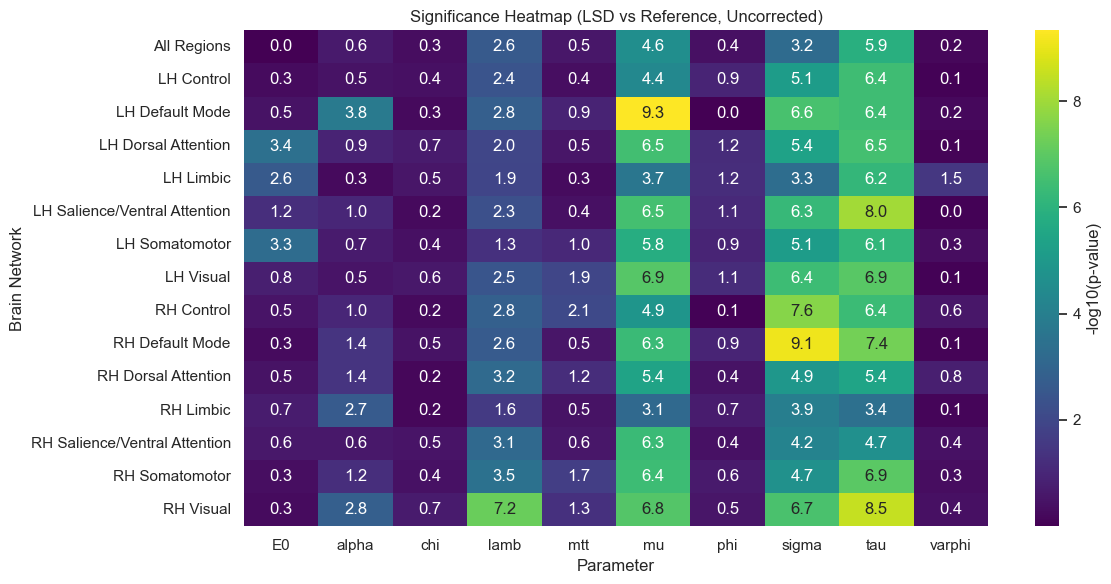

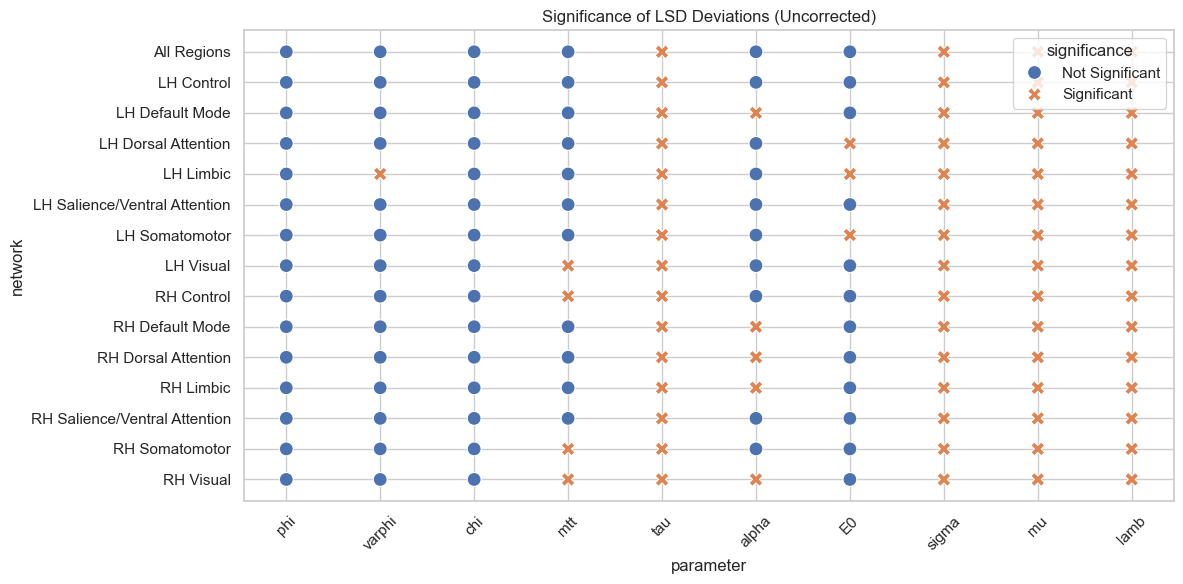

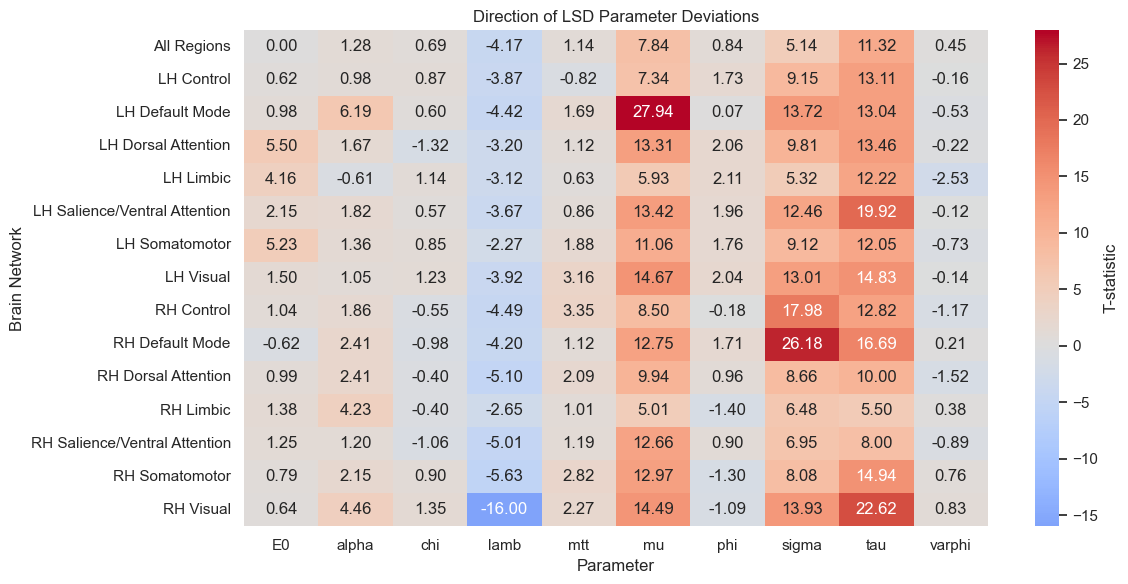

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df_lsd.pivot(index="network", columns="parameter", values="p_value")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (LSD vs Reference, Uncorrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df_lsd["significance"] = results_df_lsd["reject_raw"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df_lsd,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD Deviations (Uncorrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


heatmap_vals_lsd = results_df_lsd.copy()

heatmap_matrix_lsd = heatmap_vals_lsd.pivot(index="network", columns="parameter", values="t_stat")

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_matrix_lsd,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={"label": "T-statistic"}
)
plt.title("Direction of LSD Parameter Deviations")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

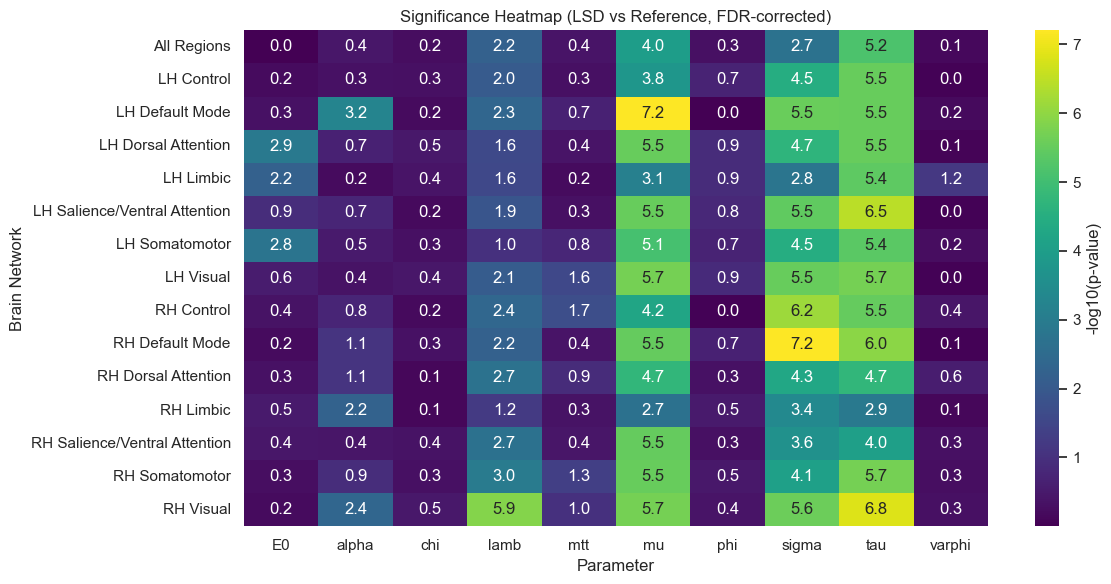

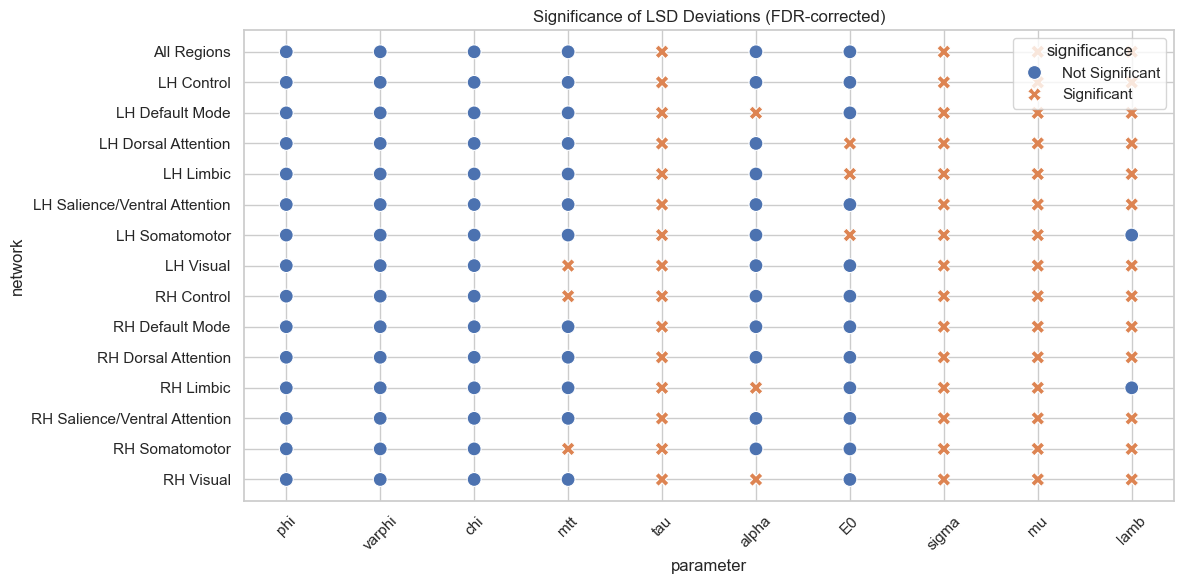

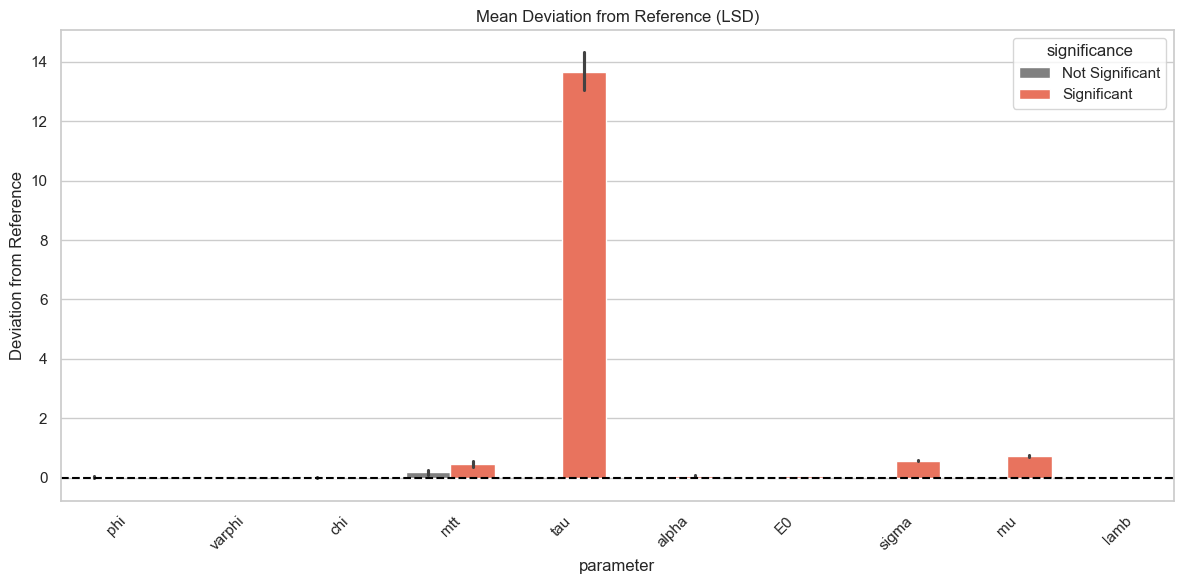

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df_lsd.pivot(index="network", columns="parameter", values="p_fdr_bh")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (LSD vs Reference, FDR-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df_lsd["significance"] = results_df_lsd["reject_fdr_bh"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df_lsd,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD Deviations (FDR-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

results_df_lsd["mean_diff"] = results_df_lsd["mean"] - results_df_lsd["reference"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df_lsd, x="parameter", y="mean_diff", hue="significance",
    palette={"Significant": "tomato", "Not Significant": "gray"}
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Mean Deviation from Reference (LSD)")
plt.ylabel("Deviation from Reference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


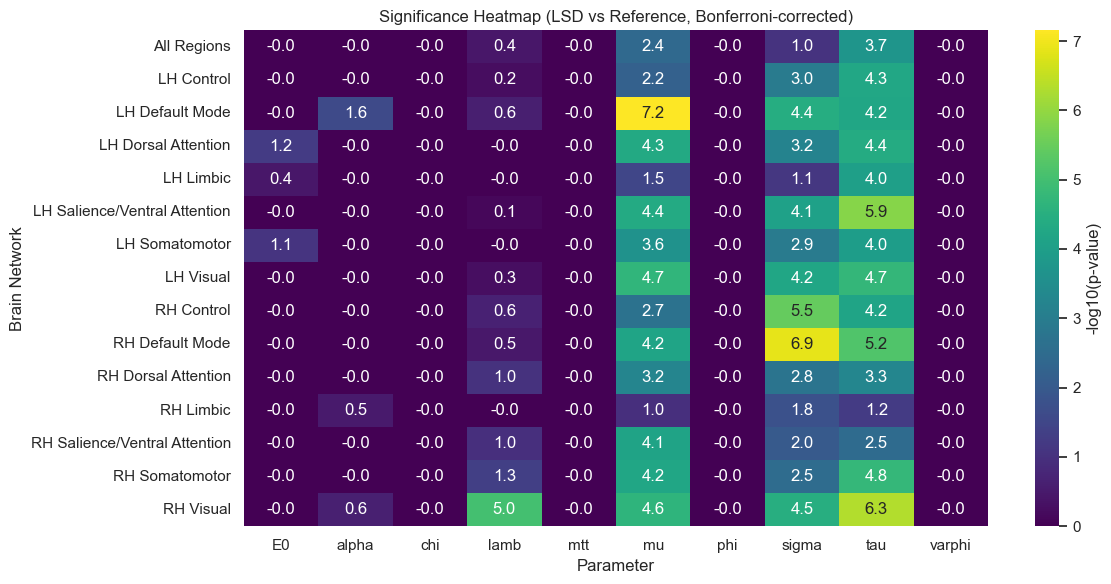

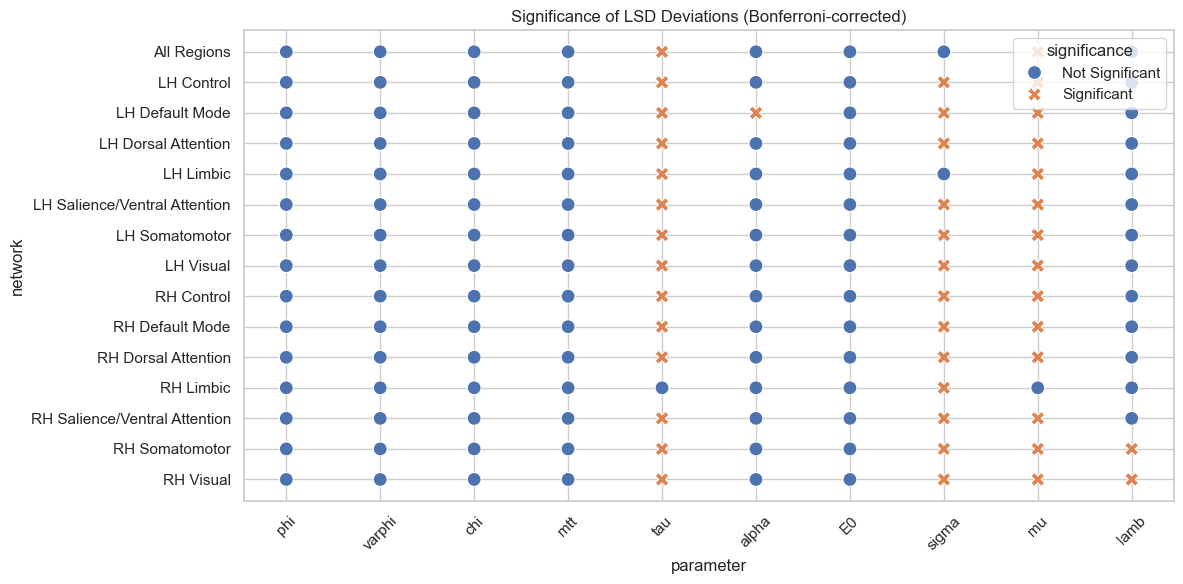

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df_lsd.pivot(index="network", columns="parameter", values="p_bonferroni")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (LSD vs Reference, Bonferroni-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df_lsd["significance"] = results_df_lsd["reject_bonferroni"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df_lsd,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD Deviations (Bonferroni-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




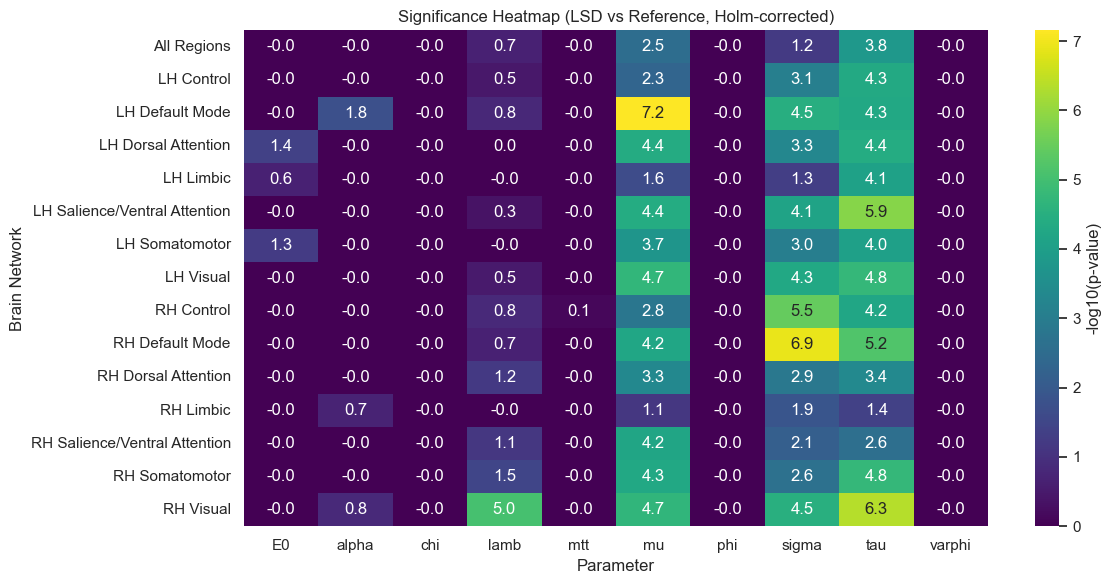

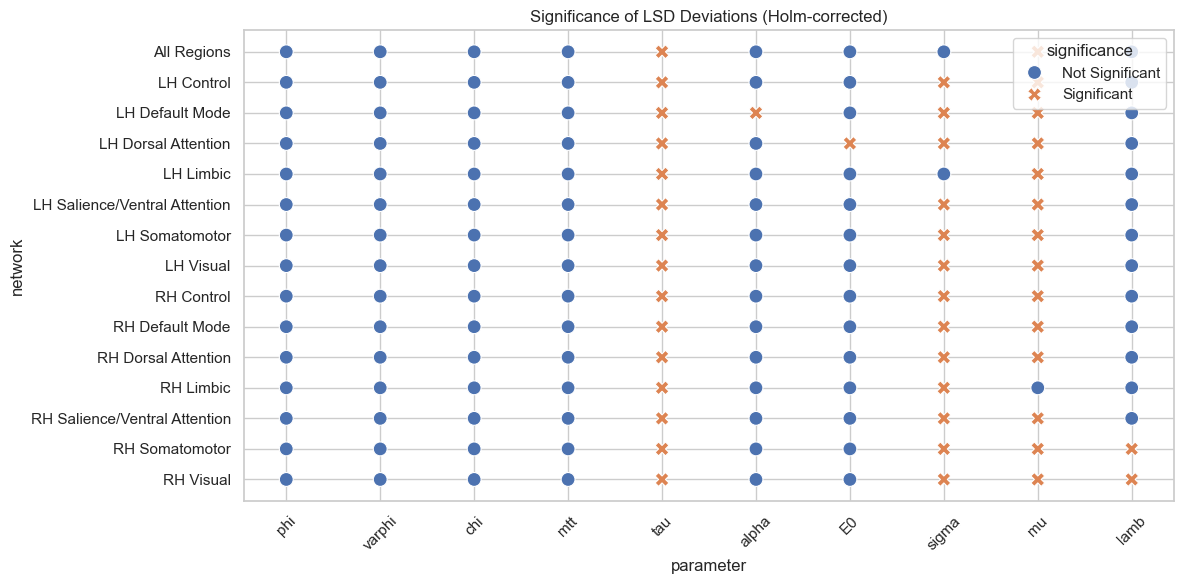

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pivot FDR p-values for heatmap
heatmap_df = results_df_lsd.pivot(index="network", columns="parameter", values="p_holm")

plt.figure(figsize=(12, 6))
sns.heatmap(
    -np.log10(heatmap_df),
    cmap="viridis",
    cbar_kws={"label": "-log10(p-value)"},
    annot=True,
    fmt=".1f"
)
plt.title("Significance Heatmap (LSD vs Reference, Holm-corrected)")
plt.ylabel("Brain Network")
plt.xlabel("Parameter")
plt.tight_layout()
plt.show()

# Mark significance status
results_df_lsd["significance"] = results_df_lsd["reject_holm"].map({True: "Significant", False: "Not Significant"})

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_df_lsd,
    x="parameter", y="network",
    hue="significance", style="significance",
    s=100
)
plt.title("Significance of LSD Deviations (Holm-corrected)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Paired t-tests (fitted vs baseline):
mse: t=-123.117, p=0, mean Δ=-0.3182 (↓)
nmse: t=-224.170, p=0, mean Δ=-0.3163 (↓)
relative_error: t=-222.724, p=0, mean Δ=-0.1973 (↓)
explained_variance: t=250.339, p=0, mean Δ=0.3258 (↑)
pearson_corr: t=134.723, p=0, mean Δ=0.1764 (↑)
cross_correlation: t=134.723, p=0, mean Δ=0.1764 (↑)
coherence: t=277.026, p=0, mean Δ=0.2311 (↑)
kl_divergence: t=-296.672, p=0, mean Δ=-0.5810 (↓)


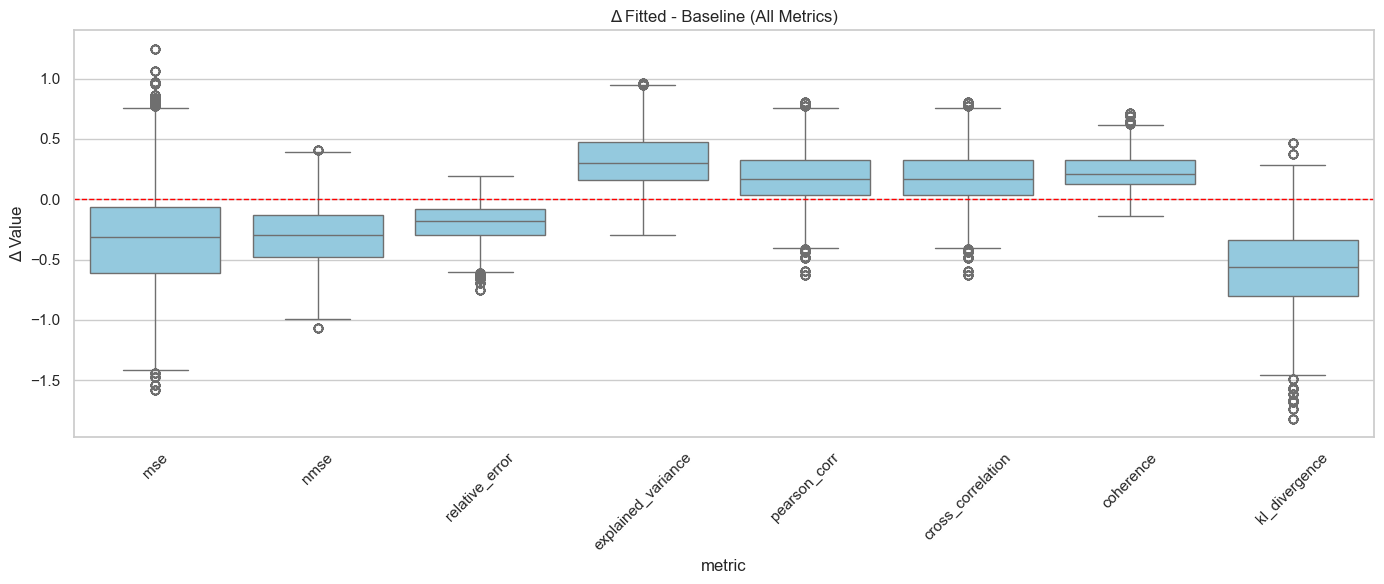

/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_93667/2075304027.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_93667/2075304027.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)


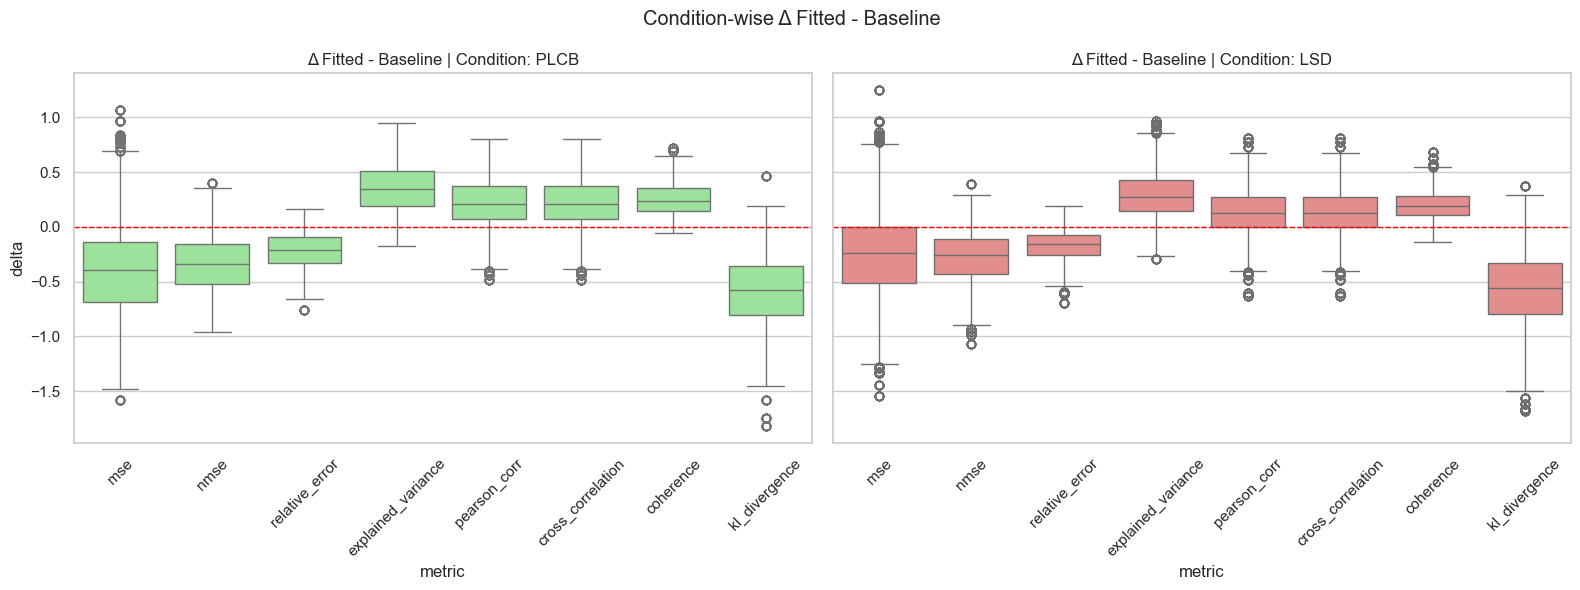

/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_93667/2075304027.py:67: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=metrics_df, x="metric", y="delta", hue="experiment",


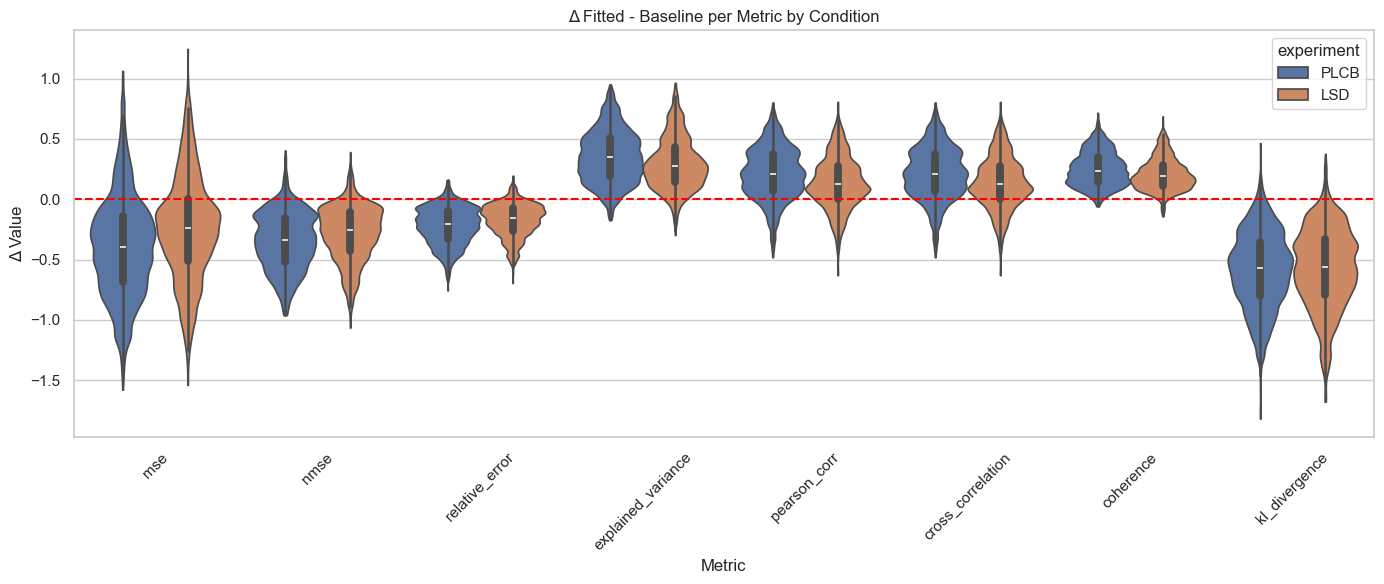

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

df = pd.read_csv("/Users/xuenbei/Desktop/finalyearproject/statistical_tests/pdcm_all_data.csv")

# Define evaluation metrics
metrics_to_use = ["mse", "nmse", "relative_error", "explained_variance",
                  "pearson_corr", "cross_correlation", "coherence", "kl_divergence"]

# Melt fitted and baseline values
rows = []
for m in metrics_to_use:
    raw_col = f"{m}_norm"
    base_col = f"baseline_{m}_norm"

    if raw_col in df.columns and base_col in df.columns:
        for _, row in df.iterrows():
            if not pd.isna(row[raw_col]) and not pd.isna(row[base_col]):
                rows.append({
                    "subject": row["subject"],
                    "roi": row["roi"],
                    "experiment": row["experiment"],
                    "metric": m,
                    "fitted": row[raw_col],
                    "baseline": row[base_col],
                    "delta": row[raw_col] - row[base_col]
                })

metrics_df = pd.DataFrame(rows)

print("Paired t-tests (fitted vs baseline):")
for metric in metrics_to_use:
    sub_df = metrics_df[metrics_df["metric"] == metric]
    x = sub_df["fitted"]
    y = sub_df["baseline"]
    valid = x.notna() & y.notna()
    t_stat, p_val = ttest_rel(x[valid], y[valid])
    mean_change = (x - y).mean()
    direction = "↓" if mean_change < 0 else "↑"
    print(f"{metric}: t={t_stat:.3f}, p={p_val:.4g}, mean Δ={mean_change:.4f} ({direction})")

plt.figure(figsize=(14, 6))
sns.boxplot(data=metrics_df, x="metric", y="delta", color="skyblue")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Δ Fitted - Baseline (All Metrics)")
plt.ylabel("Δ Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
for i, cond in enumerate(["PLCB", "LSD"]):
    subset = metrics_df[metrics_df["experiment"] == cond]
    sns.boxplot(data=subset, x="metric", y="delta", ax=axs[i],
                color="lightgreen" if cond == "PLCB" else "lightcoral")
    axs[i].axhline(0, color="red", linestyle="--", linewidth=1)
    axs[i].set_title(f"Δ Fitted - Baseline | Condition: {cond}")
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
plt.suptitle("Condition-wise Δ Fitted - Baseline")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(data=metrics_df, x="metric", y="delta", hue="experiment",
               inner="box", scale="width", cut=0)
plt.axhline(0, color='red', linestyle='--')
plt.title("Δ Fitted - Baseline per Metric by Condition")
plt.ylabel("Δ Value")
plt.xlabel("Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Paired t-tests (fitted vs baseline):
mse: t=-32.897, p=4.629e-190, mean Δ=-0.3182 (↓)
nmse: t=-59.898, p=0, mean Δ=-0.3163 (↓)
relative_error: t=-59.512, p=0, mean Δ=-0.1973 (↓)
explained_variance: t=66.890, p=0, mean Δ=0.3258 (↑)
pearson_corr: t=35.998, p=3.457e-219, mean Δ=0.1764 (↑)
coherence: t=74.021, p=0, mean Δ=0.2311 (↑)


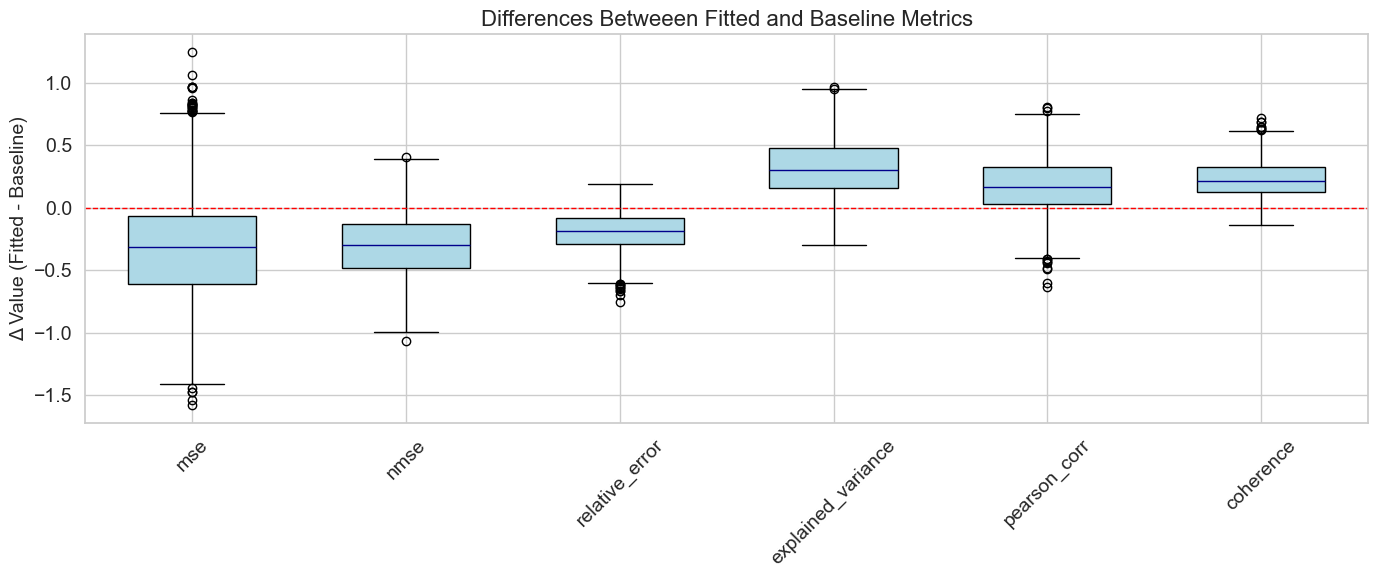

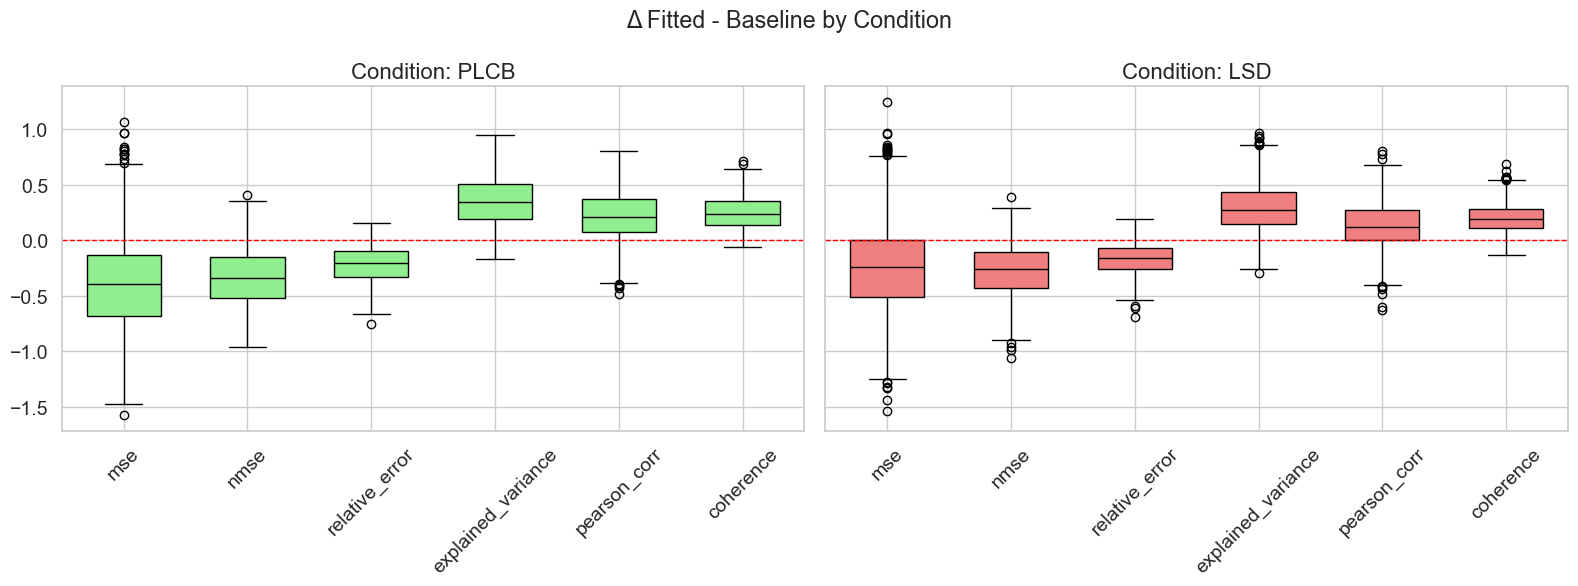

/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_93667/1818683194.py:122: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


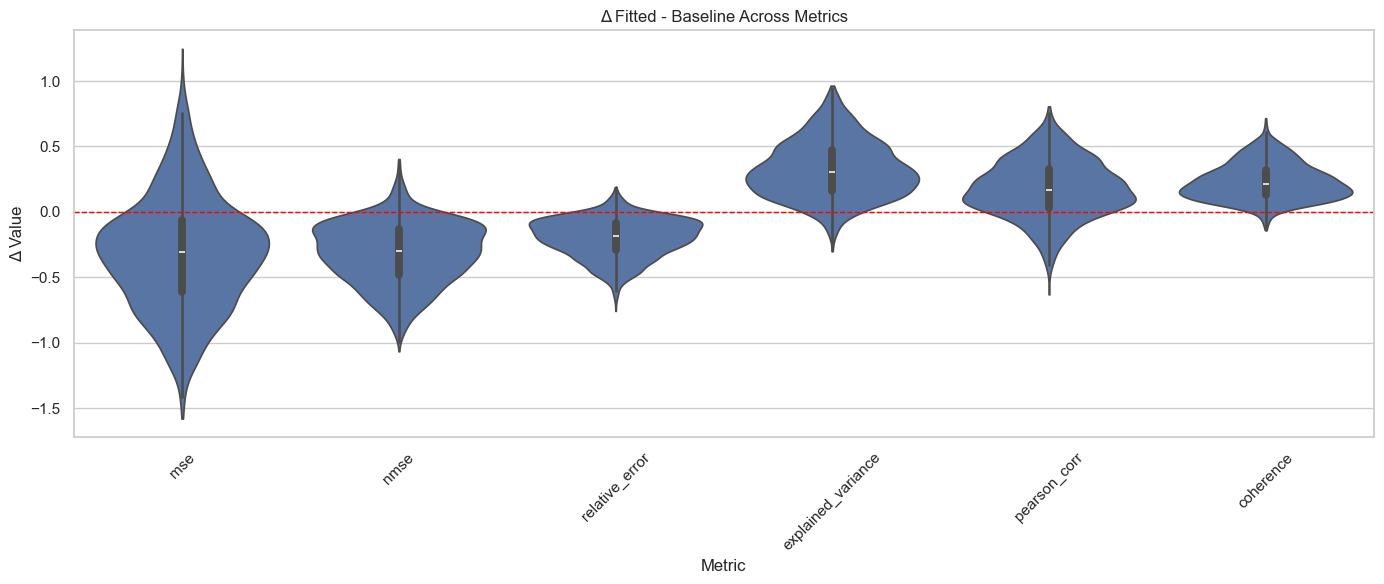

In [ ]:
import os
import json
import pandas as pd
from scipy.stats import ttest_rel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


base_dir = "/Users/xuenbei/Desktop/finalyearproject/PDCM/fitted_data"
subjects = [1, 2, 3, 4, 6, 10, 11, 12, 19, 20]
rois = list(range(100))
conditions = ["PLCB", "LSD"]
metrics_to_use = ["mse", "nmse", "relative_error", "explained_variance",
                  "pearson_corr", "coherence"]

rows = []

for subj in subjects:
    for roi in rois:
        for exp in conditions:
            prefix = f"roi-{roi}-{exp}"
            folder = os.path.join(base_dir, f"sub-{subj:03d}")

            try:
                with open(os.path.join(folder, f"{prefix}_metrics.json")) as f1, \
                     open(os.path.join(folder, f"{prefix}_baseline_metrics.json")) as f2:

                    fitted = json.load(f1)["normalised_csd_metrics"]
                    baseline = json.load(f2)["normalised_csd_metrics"]

                    row = {"subject": subj, "roi": roi, "condition": exp}
                    for metric in metrics_to_use:
                        row[f"{metric}_fitted"] = fitted.get(metric)
                        row[f"{metric}_baseline"] = baseline.get(metric)
                        row[f"{metric}_delta"] = fitted.get(metric) - baseline.get(metric)
                    rows.append(row)

            except Exception as e:
                print(f"Missing or error for sub-{subj:03d}, ROI {roi}, {exp}: {e}")

df = pd.DataFrame(rows)

print("Paired t-tests (fitted vs baseline):")
for metric in metrics_to_use:
    x = df[f"{metric}_fitted"]
    y = df[f"{metric}_baseline"]
    valid = x.notna() & y.notna()
    t_stat, p_val = ttest_rel(x[valid], y[valid])
    mean_change = (x - y).mean()
    direction = "↓" if mean_change < 0 else "↑"
    print(f"{metric}: t={t_stat:.3f}, p={p_val:.4g}, mean Δ={mean_change:.4f} ({direction})")


# Melt the DataFrame to long format for plotting
plot_data = df.melt(
    id_vars=["subject", "roi", "condition"],
    value_vars=[f"{m}_delta" for m in metrics_to_use],
    var_name="metric",
    value_name="delta"
)

plot_data["metric"] = plot_data["metric"].str.replace("_delta", "")


plt.rcParams.update({
    'font.size': 14,         
    'axes.titlesize': 16,   
    'axes.labelsize': 14,    
    'xtick.labelsize': 14,  
    'ytick.labelsize': 14,   
    'legend.fontsize': 14,   
})



metrics = plot_data["metric"].unique()

fig, ax = plt.subplots(figsize=(14, 6))
positions = np.arange(len(metrics))
data = [plot_data[plot_data["metric"] == m]["delta"].dropna() for m in metrics]

ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='black'),
           medianprops=dict(color='darkblue'))

ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xticks(positions)
ax.set_xticklabels(metrics, rotation=45)
ax.set_ylabel("Δ Value (Fitted - Baseline)")
ax.set_title("Differences Betweeen Fitted and Baseline Metrics")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for idx, cond in enumerate(["PLCB", "LSD"]):
    ax = axs[idx]
    subset = plot_data[plot_data["condition"] == cond]
    data = [subset[subset["metric"] == m]["delta"].dropna() for m in metrics]

    ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True,
               boxprops=dict(facecolor='lightgreen' if cond == "PLCB" else 'lightcoral', color='black'),
               medianprops=dict(color='black'))

    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.set_xticks(positions)
    ax.set_xticklabels(metrics, rotation=45)
    ax.set_title(f"Condition: {cond}")

fig.suptitle("Δ Fitted - Baseline by Condition")
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))
sns.violinplot(
    data=plot_data,
    x="metric", y="delta",
    inner="box", scale="width", cut=0
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Δ Fitted - Baseline Across Metrics")
plt.ylabel("Δ Value")
plt.xlabel("Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



/var/folders/0j/8rw9s9dd56v924gjnszhk07m0000gn/T/ipykernel_93667/2978693225.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=20)


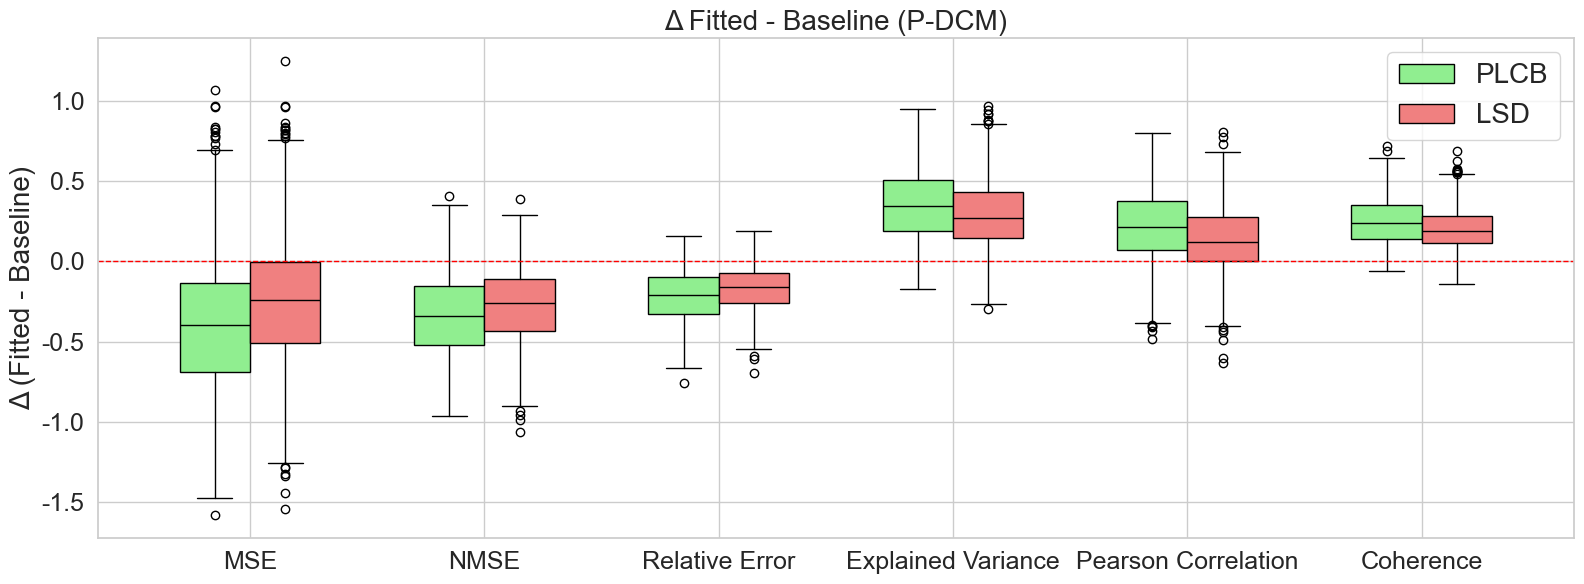

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

metrics_to_use = ["mse", "nmse", "relative_error", "explained_variance", "pearson_corr", "coherence"]
metric_label_map = {
    "mse": "MSE",
    "nmse": "NMSE",
    "relative_error": "Relative Error",
    "explained_variance": "Explained Variance",
    "pearson_corr": "Pearson Correlation",
    "coherence": "Coherence"
}
display_labels = [metric_label_map[m] for m in metrics_to_use]
positions = np.arange(len(metrics_to_use))
width = 0.3
offset = width / 2

data_plcb = [plot_data[(plot_data["metric"] == m) & (plot_data["condition"] == "PLCB")]["delta"].dropna()
             for m in metrics_to_use]

data_lsd = [plot_data[(plot_data["metric"] == m) & (plot_data["condition"] == "LSD")]["delta"].dropna()
            for m in metrics_to_use]

fig, ax = plt.subplots(figsize=(16, 6))
positions_plcb = positions - offset
positions_lsd = positions + offset

bp1 = ax.boxplot(data_plcb, positions=positions_plcb, widths=width, patch_artist=True,
                 boxprops=dict(facecolor='lightgreen', color='black'),
                 medianprops=dict(color='black'))

bp2 = ax.boxplot(data_lsd, positions=positions_lsd, widths=width, patch_artist=True,
                 boxprops=dict(facecolor='lightcoral', color='black'),
                 medianprops=dict(color='black'))

ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xticks(positions)
ax.set_xticklabels(display_labels, fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=20)
ax.set_ylabel("Δ (Fitted - Baseline)", fontsize=20)
ax.set_title("Δ Fitted - Baseline (P-DCM)", fontsize=20)
ax.tick_params(labelsize=18)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["PLCB", "LSD"], fontsize=20)

plt.tight_layout()
plt.show()


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_rel

json_dir = '/Users/xuenbei/Desktop/finalyearproject/PDCM/fitted_data/'
region_to_include = 52
subjects_to_include = [1, 2, 3, 4, 6, 10, 11, 12, 19, 20]  

json_files = []
for root, dirs, files in os.walk(json_dir):
    for file in files:
        if file.endswith('_results.json'):
            json_files.append(os.path.join(root, file))

all_data = []

for file_path in json_files:
    with open(file_path, 'r') as f:
        data = json.load(f)
        if data['region'] != region_to_include:
            continue
        if data['subject_id'] not in subjects_to_include:
            continue

        condition = data['experiment']
        region = data['region']
        subject_id = data['subject_id']

        for param, value in data['final_parameters'].items():
            if param == 'A' and isinstance(value, list):
                try:
                    value = float(value[0][0][0])  # Real part of A[0][0]
                except Exception:
                    continue

            all_data.append({
                'Subject': subject_id,
                'Condition': condition,
                'Region': region,
                'Parameter': param,
                'Value': value
            })

df = pd.DataFrame(all_data)

plt.figure(figsize=(14, 7))
sns.boxplot(x='Parameter', y='Value', hue='Condition', data=df)
plt.title(f'Parameter Distribution for Region {region_to_include} (Boxplot)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.violinplot(x='Parameter', y='Value', hue='Condition', data=df, split=True)
plt.title(f'Parameter Distribution for Region {region_to_include} (Violin Plot)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Literature/reference values for each parameter
literature_values = {
    'varphi': 0.6,
    'phi': 1.5,
    'chi': 0.6,
    'mtt': (1, 5.0),
    'tau': (0,30),
    'alpha': 0.32,
    'E0': 0.4
}

# Boxplot with literature reference lines
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='Parameter', y='Value', hue='Condition', data=df, hue_order=['PLCB', 'LSD'])
plt.title(f'Parameter Distribution for Region {region_to_include}', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Parameter", fontsize=14)
plt.ylabel("Value", fontsize=14)

# Number of parameters
n_params = len(ax.get_xticks())
band_width = 1.0 / n_params

for i, label in enumerate(ax.get_xticklabels()):
    param_name = label.get_text()
    if param_name in literature_values:
        value = literature_values[param_name]
        # Compute xmin and xmax for this parameter
        xmin = i / n_params
        xmax = (i + 1) / n_params
        
        if isinstance(value, (tuple, list)) and len(value) == 2:
            # Shaded red band for a literature range
            ax.axhspan(value[0], value[1], color='red', alpha=0.2, xmin=xmin, xmax=xmax)
        else:
            # Dashed red line for a single value
            ax.axhline(y=value, color='red', linestyle='--', xmin=xmin, xmax=xmax)

from matplotlib.patches import Patch
red_band = Patch(facecolor='red', alpha=0.2, label='Literature Range')
red_line = plt.Line2D([], [], color='red', linestyle='--', label='Literature Value')
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles + [red_line], labels + ['Literature Value'], title="Legend")

plt.tight_layout()
plt.show()


print(f"\nIndependent T-Test Results for Region {region_to_include}:")
for param in df['Parameter'].unique():
    lsd_vals = df[(df['Parameter'] == param) & (df['Condition'] == 'LSD')]['Value']
    plc_vals = df[(df['Parameter'] == param) & (df['Condition'] == 'PLCB')]['Value']
    if len(lsd_vals) > 1 and len(plc_vals) > 1:
        t_stat, p_val = ttest_ind(lsd_vals, plc_vals, equal_var=False)
        print(f"{param}: t = {t_stat:.3f}, p = {p_val:.3f}")
    else:
        print(f"{param}: Not enough data for independent t-test.")

print(f"\nPaired T-Test Results for Region {region_to_include}:")
for param in df['Parameter'].unique():
    df_param = df[df['Parameter'] == param]
    df_pivot = df_param.pivot(index='Subject', columns='Condition', values='Value')

    if 'LSD' in df_pivot.columns and 'PLCB' in df_pivot.columns:
        paired = df_pivot.dropna()
        if len(paired) > 1:
            t_stat, p_val = ttest_rel(paired['LSD'], paired['PLCB'])
            print(f"{param}: paired t = {t_stat:.3f}, p = {p_val:.3f}")
        else:
            print(f"{param}: Not enough paired data.")
    else:
        print(f"{param}: Missing LSD or PLCB data.")